# Metrics Analysis Notebook

This notebook analyzes the metrics computed from experiment results, including:
- Accuracy metrics across different forms and label types
- Confident-Abstain (CA) scores
- Hedging (HEDGE) scores
- Residual stream analysis for abstention direction

## Setup and Data Loading


In [ ]:
try:
    import pickle
    from datetime import datetime
    from pathlib import Path

    # Define the save directory
    save_dir = Path("./results/abstention_direction")
    saved_data_exists = False

    if save_dir.exists():
        # Look for saved residual vector files
        saved_files = list(save_dir.glob("residual_vectors_*.pkl"))

        if saved_files:
            # Sort by modification time (most recent first)
            latest_file = max(saved_files, key=lambda f: f.stat().st_mtime)

            print(f"Found saved residual vectors: {latest_file}")
            print(f"Last modified: {datetime.fromtimestamp(latest_file.stat().st_mtime)}")

            # Use the saved data
            use_saved_data = True  # Set to True to skip extraction if saved data exists

            if use_saved_data:
                with open(latest_file, 'rb') as f:
                    saved_data = pickle.load(f)

                # Check if the saved data has the expected structure
                if 'residual_vectors' in saved_data and 'residual_vectors_by_layer' in saved_data:
                    # Load the data into the appropriate variables
                    residual_vectors = saved_data['residual_vectors']
                    residual_vectors_by_layer = saved_data['residual_vectors_by_layer']

                    # Print some information about the loaded data
                    num_layers = len(residual_vectors_by_layer)
                    layer_indices = sorted(residual_vectors_by_layer.keys())

                    print(f"Successfully loaded data for {num_layers} layers: {layer_indices}")

                    if layer_indices:
                        first_layer = layer_indices[0]
                        first_layer_data = residual_vectors_by_layer[first_layer]

                        print(f"\nLayer {first_layer} details:")
                        print(f"  Positive examples: {first_layer_data['positive'].shape}")
                        print(f"  Negative examples: {first_layer_data['negative'].shape}")
                        print(f"  Vector dimension: {first_layer_data['positive'][0].shape}")

                    print("\nReady for Fisher LDA analysis")
                    saved_data_exists = True
                else:
                    print("Saved file does not contain the expected data structure")

    # If no saved data exists or couldn't be loaded, extract the vectors
    if not saved_data_exists:
        # Check if we have residual data and balanced dataset
        if 'residual_data' in locals() and 'balanced_dataset' in locals():
            print("No usable saved data found. Extracting residual vectors from the actual data...")

            # Extract vectors for all layers with incremental saving
            residual_vectors_by_layer = extract_residual_vectors(balanced_dataset, residual_data, save_incremental=True, save_frequency=3)

            # Count the number of layers with data
            num_layers_with_data = len(residual_vectors_by_layer)

            if num_layers_with_data > 0:
                print(f"Successfully extracted vectors for {num_layers_with_data} layers")

                # Print details for the first layer
                first_layer = min(residual_vectors_by_layer.keys())
                first_layer_data = residual_vectors_by_layer[first_layer]

                print(f"\nLayer {first_layer} details:")
                print(f"  Positive examples: {first_layer_data['positive'].shape}")
                print(f"  Negative examples: {first_layer_data['negative'].shape}")
                print(f"  Vector dimension: {first_layer_data['positive'][0].shape}")

                # Prepare the residual_vectors dictionary for the rest of the notebook
                residual_vectors = {
                    'positive': {layer: data['positive'] for layer, data in residual_vectors_by_layer.items()},
                    'negative': {layer: data['negative'] for layer, data in residual_vectors_by_layer.items()}
                }

                print("\nReady for Fisher LDA analysis")
            else:
                print("No matching vectors found in the residual data")
        else:
            print("Residual data or balanced dataset not available")
except Exception as e:
    print(f"Error processing residual vectors: {e}")


## Residual Stream Vector Extraction with Auto-Save

The following cells implement:
1. A function to extract residual vectors with incremental auto-saving
2. A consolidated process that first checks for saved data before extraction

This approach prevents data loss during kernel crashes by saving progress frequently.


# Analyzing Abstention and Hedging Metrics

This notebook provides visualizations and analysis of the Confident-Abstain (CA) and Hedging (HEDGE) metrics computed over the experimental results.


In [4]:
import json
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

# Add the project root to the path to allow imports
repo_root = Path().absolute()
sys.path.insert(0, str(repo_root))



## Load the Metrics Data

First, let's load the metrics data that was generated by the `run_metrics_analysis.py` script.


In [5]:
# Path to the metrics directory
metrics_dir = Path('./results/metrics_analysis')

# Find all run directories
run_dirs = [d for d in metrics_dir.iterdir() if d.is_dir() and d.name.startswith('run_')]

if not run_dirs:
    print("No metrics data found. Please run the run_metrics_analysis.py script first.")
else:
    print(f"Found {len(run_dirs)} runs with metrics data:")
    for d in run_dirs:
        print(f"  - {d.name}")

    # Use the most recent run by default
    latest_run = sorted(run_dirs)[-1]
    print(f"\nUsing latest run: {latest_run.name}")


Found 1 runs with metrics data:
  - run_20250911_062422

Using latest run: run_20250911_062422


In [7]:
# Load the all_metrics.csv file from the latest run
try:
    metrics_file = latest_run / 'all_metrics.csv'
    metrics_df = pd.read_csv(metrics_file)
    print(f"Loaded {len(metrics_df)} metric records")

    # Display the first few rows and column names
    print("\nColumns in metrics_df:")
    print(metrics_df.columns.tolist())
    metrics_df.head()
except NameError:
    print("No metrics data available. Please run the run_metrics_analysis.py script first.")


Loaded 63000 metric records

Columns in metrics_df:
['run', 'experiment', 'form', 'label_type', 'permutation', 'id', 'question', 'answer', 'subject', 'difficulty', 'split', 'pred_label', 'canonical_label', 'score', 'ca_score', 'hedge_score', 'canonical_probs', 'canonical_probs_norm']


## Analyze Metrics by Form

Let's analyze how the CA and HEDGE metrics vary across different prompt forms.


In [8]:
try:
    # Load the form summary
    form_summary_file = latest_run / 'form_summary.csv'
    form_df = pd.read_csv(form_summary_file)

    # Display the summary
    form_df
except NameError:
    print("No metrics data available.")


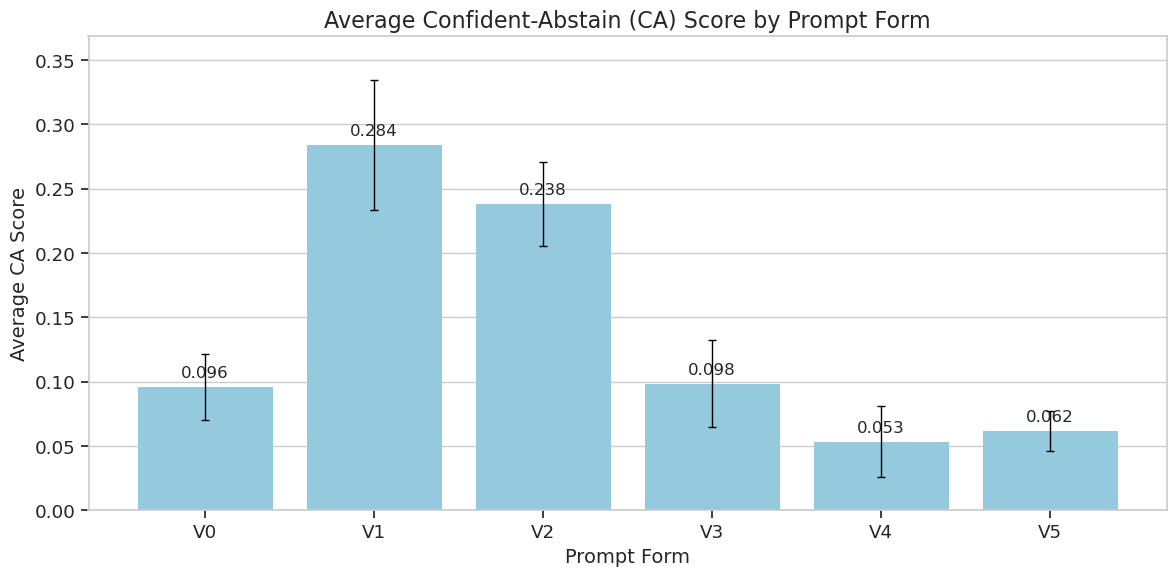

In [9]:
try:
    # Create a bar plot of CA scores by form
    plt.figure(figsize=(12, 6))

    # Sort by form
    form_df = form_df.sort_values('form')

    # First, we need to calculate standard error across permutations for each form
    # Group metrics by form and permutation to get per-experiment metrics
    if 'permutation' in metrics_df.columns:
        exp_form_metrics = metrics_df.groupby(['form', 'permutation'])['ca_score'].mean().reset_index()
    else:
        # If permutation is not available, try to extract it from experiment_name
        if 'experiment_name' in metrics_df.columns:
            # Extract permutation from experiment_name (assuming format like "V0_alpha_p1")
            metrics_df['permutation'] = metrics_df['experiment_name'].str.extract(r'p(\d+)')
            exp_form_metrics = metrics_df.groupby(['form', 'permutation'])['ca_score'].mean().reset_index()
        else:
            # If neither is available, just use form
            print("Warning: No permutation or experiment_name column found. Using only form for grouping.")
            exp_form_metrics = metrics_df.groupby(['form'])['ca_score'].mean().reset_index()
            # Add a dummy permutation column for consistency
            exp_form_metrics['permutation'] = 'p1'

    # Then calculate mean and std across permutations for each form
    form_stats = exp_form_metrics.groupby('form')['ca_score'].agg(['mean', 'std', 'count']).reset_index()
    form_stats.rename(columns={'mean': 'ca_score_mean_check'}, inplace=True)

    # Calculate standard error
    form_stats['se'] = form_stats['std'] / np.sqrt(form_stats['count'])

    # Merge with form_df to get the standard error
    form_df = pd.merge(form_df, form_stats[['form', 'se']], on='form', how='left')

    # Plot CA scores without error bars (we'll add them manually)
    ax = sns.barplot(x='form', y='ca_score_mean', data=form_df, color='skyblue', errorbar=None)

    # Add custom error bars
    for i, row in form_df.iterrows():
        x = i
        y = row['ca_score_mean']
        se = row['se']

        if not pd.isna(se) and se > 0:
            ax.errorbar(
                x, y,
                yerr=se,
                fmt='none', color='black', capsize=3, elinewidth=1
            )

    # Add labels and title
    plt.title('Average Confident-Abstain (CA) Score by Prompt Form', fontsize=16)
    plt.xlabel('Prompt Form', fontsize=14)
    plt.ylabel('Average CA Score', fontsize=14)

    # Calculate appropriate y-axis limits based on data
    max_value = form_df['ca_score_mean'].max()
    y_max = max_value * 1.3  # Add 30% padding above the max value
    plt.ylim(0, y_max)

    # Add value labels on top of bars
    for i, v in enumerate(form_df['ca_score_mean']):
        ax.text(i, v + (y_max * 0.02), f'{v:.3f}', ha='center', fontsize=12)

    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error: {str(e)}")


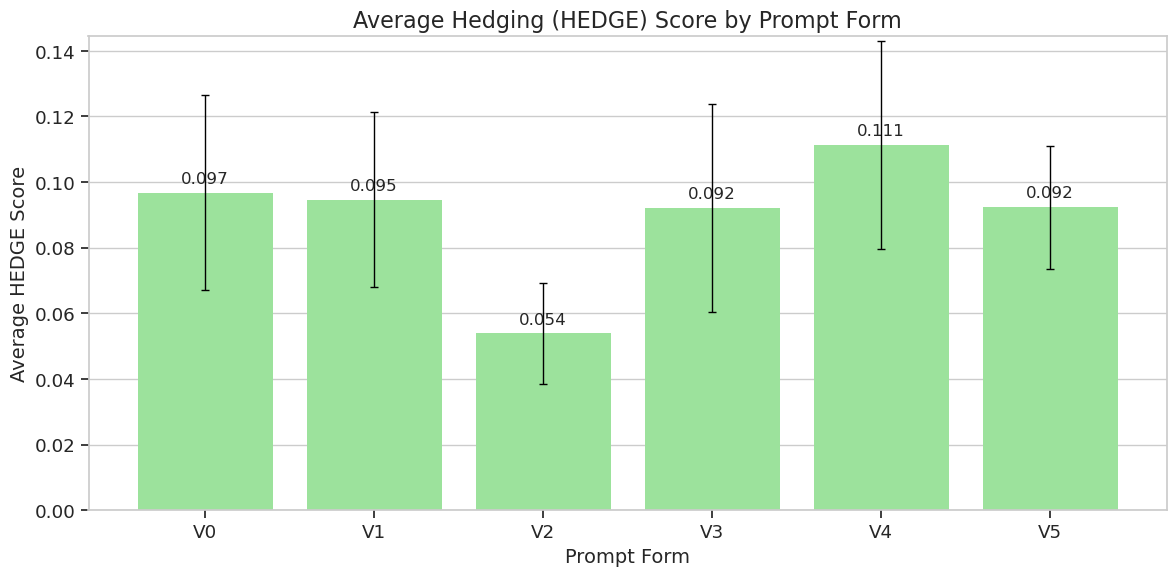

In [10]:
try:
    # Create a bar plot of HEDGE scores by form
    plt.figure(figsize=(12, 6))

    # First, we need to calculate standard error across permutations for each form
    # Group metrics by form and permutation to get per-experiment metrics
    if 'permutation' in metrics_df.columns:
        exp_form_metrics = metrics_df.groupby(['form', 'permutation'])['hedge_score'].mean().reset_index()
    else:
        # If permutation is not available, try to extract it from experiment_name
        if 'experiment_name' in metrics_df.columns:
            # Extract permutation from experiment_name (assuming format like "V0_alpha_p1")
            if 'permutation' not in metrics_df.columns:  # Only extract if not already done
                metrics_df['permutation'] = metrics_df['experiment_name'].str.extract(r'p(\d+)')
            exp_form_metrics = metrics_df.groupby(['form', 'permutation'])['hedge_score'].mean().reset_index()
        else:
            # If neither is available, just use form
            print("Warning: No permutation or experiment_name column found. Using only form for grouping.")
            exp_form_metrics = metrics_df.groupby(['form'])['hedge_score'].mean().reset_index()
            # Add a dummy permutation column for consistency
            exp_form_metrics['permutation'] = 'p1'

    # Then calculate mean and std across permutations for each form
    form_stats = exp_form_metrics.groupby('form')['hedge_score'].agg(['mean', 'std', 'count']).reset_index()
    form_stats.rename(columns={'mean': 'hedge_score_mean_check'}, inplace=True)

    # Calculate standard error
    form_stats['se'] = form_stats['std'] / np.sqrt(form_stats['count'])

    # Merge with form_df to get the standard error
    form_df = pd.merge(form_df, form_stats[['form', 'se']], on='form', how='left', suffixes=('', '_hedge'))

    # Plot HEDGE scores without error bars (we'll add them manually)
    ax = sns.barplot(x='form', y='hedge_score_mean', data=form_df, color='lightgreen', errorbar=None)

    # Add custom error bars
    for i, row in form_df.iterrows():
        x = i
        y = row['hedge_score_mean']
        se = row['se_hedge'] if 'se_hedge' in row else row['se']

        if not pd.isna(se) and se > 0:
            ax.errorbar(
                x, y,
                yerr=se,
                fmt='none', color='black', capsize=3, elinewidth=1
            )

    # Add labels and title
    plt.title('Average Hedging (HEDGE) Score by Prompt Form', fontsize=16)
    plt.xlabel('Prompt Form', fontsize=14)
    plt.ylabel('Average HEDGE Score', fontsize=14)

    # Calculate appropriate y-axis limits based on data
    max_value = form_df['hedge_score_mean'].max()
    y_max = max_value * 1.3  # Add 30% padding above the max value
    plt.ylim(0, y_max)

    # Add value labels on top of bars
    for i, v in enumerate(form_df['hedge_score_mean']):
        ax.text(i, v + (y_max * 0.02), f'{v:.3f}', ha='center', fontsize=12)

    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error: {str(e)}")


## Analyze Metrics by Label Type

Let's analyze how the metrics vary between alphabetic (A,B,C,D,E) and numeric (1,2,3,4,5) labels.


In [11]:
try:
    # Load the label type summary
    label_summary_file = latest_run / 'label_type_summary.csv'
    label_df = pd.read_csv(label_summary_file)

    # Display the summary
    label_df
except NameError:
    print("No metrics data available.")


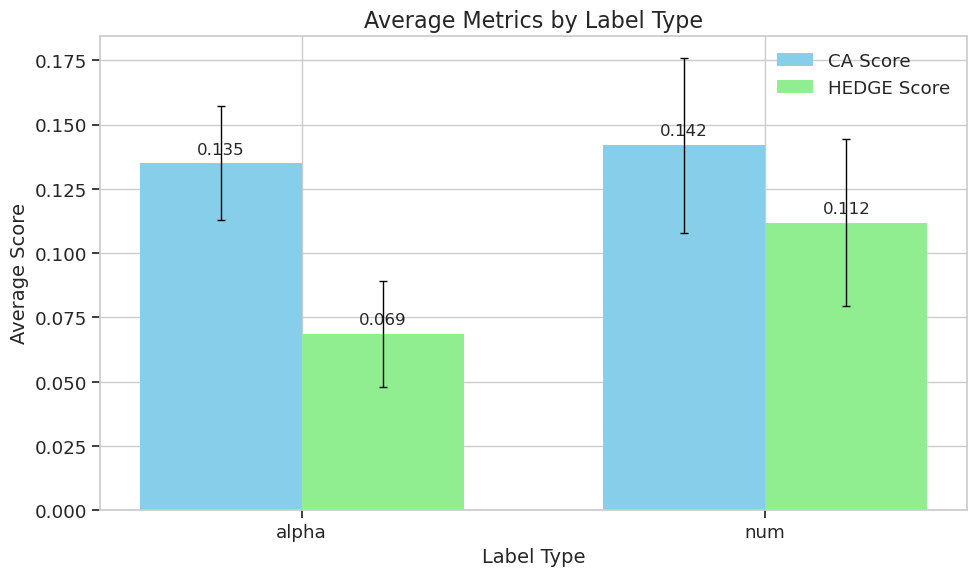

In [12]:
try:
    # Create a grouped bar plot for CA and HEDGE scores by label type
    plt.figure(figsize=(10, 6))

    # First, calculate standard errors across permutations for each label type
    # Group metrics by label_type and permutation to get per-experiment metrics
    if 'permutation' in metrics_df.columns:
        exp_label_ca = metrics_df.groupby(['label_type', 'permutation'])['ca_score'].mean().reset_index()
        exp_label_hedge = metrics_df.groupby(['label_type', 'permutation'])['hedge_score'].mean().reset_index()
    else:
        # If permutation is not available, try to extract it from experiment_name
        if 'experiment_name' in metrics_df.columns:
            # Extract permutation from experiment_name (assuming format like "V0_alpha_p1")
            if 'permutation' not in metrics_df.columns:  # Only extract if not already done
                metrics_df['permutation'] = metrics_df['experiment_name'].str.extract(r'p(\d+)')
            exp_label_ca = metrics_df.groupby(['label_type', 'permutation'])['ca_score'].mean().reset_index()
            exp_label_hedge = metrics_df.groupby(['label_type', 'permutation'])['hedge_score'].mean().reset_index()
        else:
            # If neither is available, just use label_type
            print("Warning: No permutation or experiment_name column found. Using only label_type for grouping.")
            exp_label_ca = metrics_df.groupby(['label_type'])['ca_score'].mean().reset_index()
            exp_label_hedge = metrics_df.groupby(['label_type'])['hedge_score'].mean().reset_index()
            # Add a dummy permutation column for consistency
            exp_label_ca['permutation'] = 'p1'
            exp_label_hedge['permutation'] = 'p1'

    # Then calculate mean and std across permutations for each label type
    label_ca_stats = exp_label_ca.groupby('label_type')['ca_score'].agg(['mean', 'std', 'count']).reset_index()
    label_hedge_stats = exp_label_hedge.groupby('label_type')['hedge_score'].agg(['mean', 'std', 'count']).reset_index()

    # Calculate standard error
    label_ca_stats['se'] = label_ca_stats['std'] / np.sqrt(label_ca_stats['count'])
    label_hedge_stats['se'] = label_hedge_stats['std'] / np.sqrt(label_hedge_stats['count'])

    # Merge with label_df to get the standard errors
    label_df = pd.merge(label_df, label_ca_stats[['label_type', 'se']], on='label_type', how='left')
    label_df = pd.merge(label_df, label_hedge_stats[['label_type', 'se']], on='label_type', how='left', suffixes=('_ca', '_hedge'))

    # Set up positions for grouped bars
    x = np.arange(len(label_df['label_type']))
    width = 0.35

    # Create bars
    ax = plt.subplot()
    ca_bars = ax.bar(x - width/2, label_df['ca_score_mean'], width, label='CA Score', color='skyblue')
    hedge_bars = ax.bar(x + width/2, label_df['hedge_score_mean'], width, label='HEDGE Score', color='lightgreen')

    # Add error bars
    for i, row in label_df.iterrows():
        # CA score error bar
        x_pos = i - width/2
        y = row['ca_score_mean']
        se = row['se_ca']
        if not pd.isna(se) and se > 0:
            ax.errorbar(x_pos, y, yerr=se, fmt='none', color='black', capsize=3, elinewidth=1)

        # HEDGE score error bar
        x_pos = i + width/2
        y = row['hedge_score_mean']
        se = row['se_hedge']
        if not pd.isna(se) and se > 0:
            ax.errorbar(x_pos, y, yerr=se, fmt='none', color='black', capsize=3, elinewidth=1)

    # Add labels and title
    ax.set_title('Average Metrics by Label Type', fontsize=16)
    ax.set_xlabel('Label Type', fontsize=14)
    ax.set_ylabel('Average Score', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(label_df['label_type'])

    # Calculate appropriate y-axis limits based on data
    max_ca = label_df['ca_score_mean'].max()
    max_hedge = label_df['hedge_score_mean'].max()
    max_value = max(max_ca, max_hedge)
    y_max = max_value * 1.3  # Add 30% padding above the max value
    ax.set_ylim(0, y_max)

    ax.legend()

    # Add value labels on top of bars
    for bar in ca_bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + (y_max * 0.02),
                f'{height:.3f}', ha='center', fontsize=12)

    for bar in hedge_bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + (y_max * 0.02),
                f'{height:.3f}', ha='center', fontsize=12)

    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error: {str(e)}")


## Distribution of Metrics

Let's look at the distribution of CA and HEDGE scores across all questions.


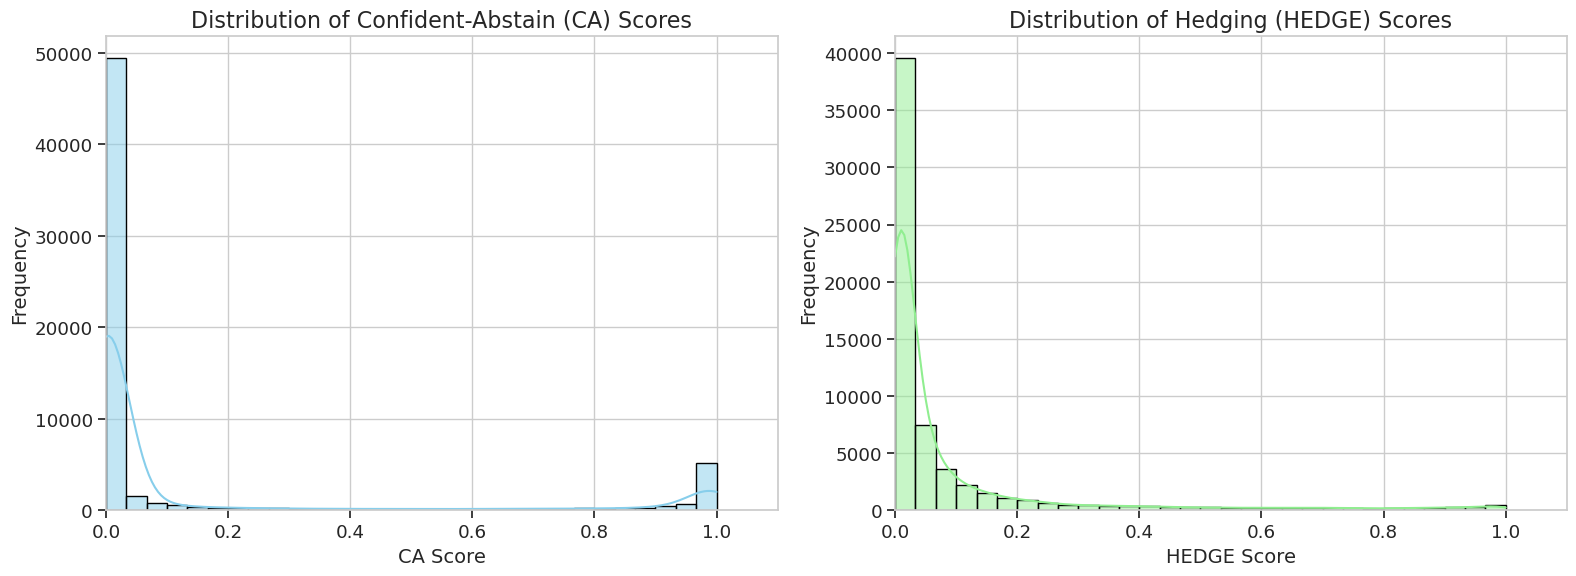

In [13]:
try:
    # Create histograms of CA and HEDGE scores
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # CA score histogram
    sns.histplot(metrics_df['ca_score'], bins=30, kde=True, ax=ax1, color='skyblue')
    ax1.set_title('Distribution of Confident-Abstain (CA) Scores', fontsize=16)
    ax1.set_xlabel('CA Score', fontsize=14)
    ax1.set_ylabel('Frequency', fontsize=14)

    # Set x-axis limit for CA scores based on data
    ca_max = metrics_df['ca_score'].max()
    ca_99th_percentile = metrics_df['ca_score'].quantile(0.99)  # Use 99th percentile to avoid outliers
    ax1.set_xlim(0, min(ca_max * 1.1, ca_99th_percentile * 1.3))

    # HEDGE score histogram
    sns.histplot(metrics_df['hedge_score'], bins=30, kde=True, ax=ax2, color='lightgreen')
    ax2.set_title('Distribution of Hedging (HEDGE) Scores', fontsize=16)
    ax2.set_xlabel('HEDGE Score', fontsize=14)
    ax2.set_ylabel('Frequency', fontsize=14)

    # Set x-axis limit for HEDGE scores based on data
    hedge_max = metrics_df['hedge_score'].max()
    hedge_99th_percentile = metrics_df['hedge_score'].quantile(0.99)  # Use 99th percentile to avoid outliers
    ax2.set_xlim(0, min(hedge_max * 1.1, hedge_99th_percentile * 1.3))

    plt.tight_layout()
    plt.show()
except NameError:
    print("No metrics data available.")


## Correlation Between Metrics and Likert Scores

Let's examine the relationship between our metrics and the Likert scores.


Correlation between CA score and Likert score: -0.0476
Correlation between HEDGE score and Likert score: -0.2082


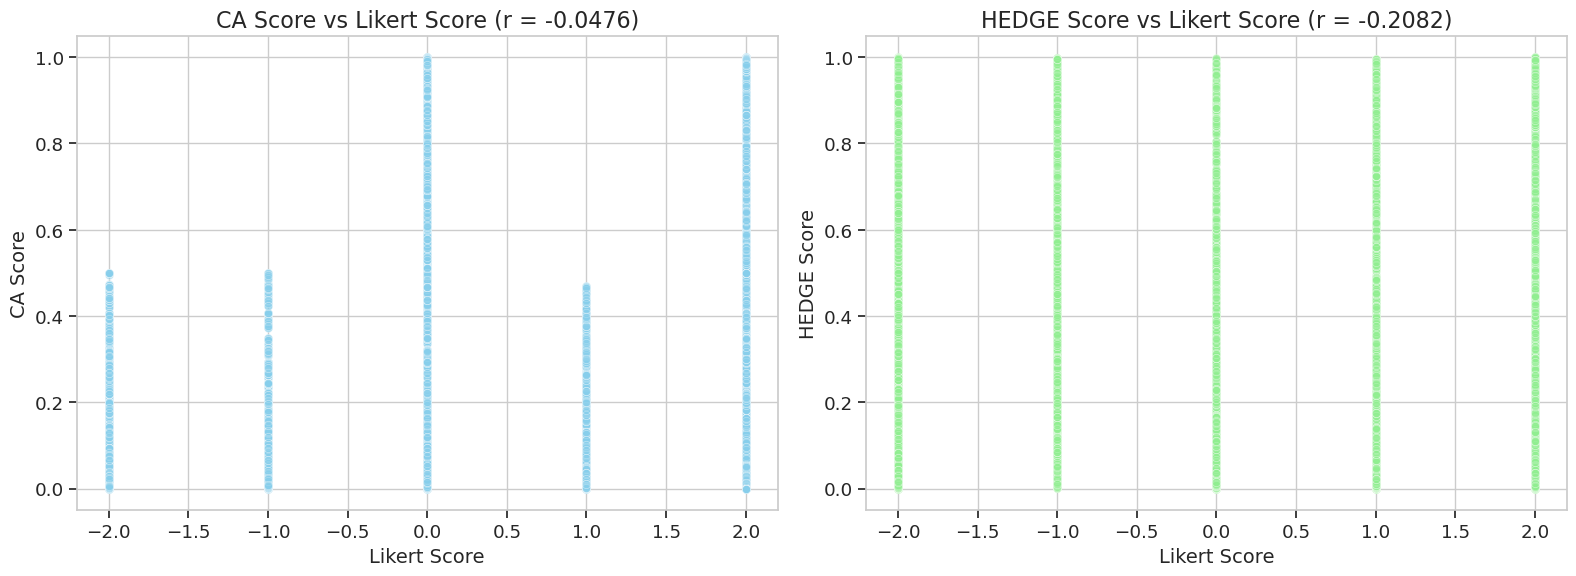

In [14]:
try:
    # Calculate correlation
    corr_ca_likert = metrics_df['ca_score'].corr(metrics_df['score'])
    corr_hedge_likert = metrics_df['hedge_score'].corr(metrics_df['score'])

    print(f"Correlation between CA score and Likert score: {corr_ca_likert:.4f}")
    print(f"Correlation between HEDGE score and Likert score: {corr_hedge_likert:.4f}")

    # Create scatter plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # CA score vs Likert score
    sns.scatterplot(x='score', y='ca_score', data=metrics_df, alpha=0.5, ax=ax1, color='skyblue')
    ax1.set_title(f'CA Score vs Likert Score (r = {corr_ca_likert:.4f})', fontsize=16)
    ax1.set_xlabel('Likert Score', fontsize=14)
    ax1.set_ylabel('CA Score', fontsize=14)

    # HEDGE score vs Likert score
    sns.scatterplot(x='score', y='hedge_score', data=metrics_df, alpha=0.5, ax=ax2, color='lightgreen')
    ax2.set_title(f'HEDGE Score vs Likert Score (r = {corr_hedge_likert:.4f})', fontsize=16)
    ax2.set_xlabel('Likert Score', fontsize=14)
    ax2.set_ylabel('HEDGE Score', fontsize=14)

    plt.tight_layout()
    plt.show()
except NameError:
    print("No metrics data available.")


## Metrics by Subject and Difficulty

Let's analyze how the metrics vary across different subjects and difficulty levels.


In [15]:
try:
    # Group by subject and compute mean metrics
    subject_summary = metrics_df.groupby('subject').agg({
        'ca_score': 'mean',
        'hedge_score': 'mean',
        'score': 'mean',
        'id': 'count'
    }).reset_index()

    subject_summary = subject_summary.rename(columns={'id': 'count'})
    subject_summary = subject_summary.sort_values('ca_score', ascending=False)

    # Display the summary
    subject_summary.head(10)
except NameError:
    print("No metrics data available.")


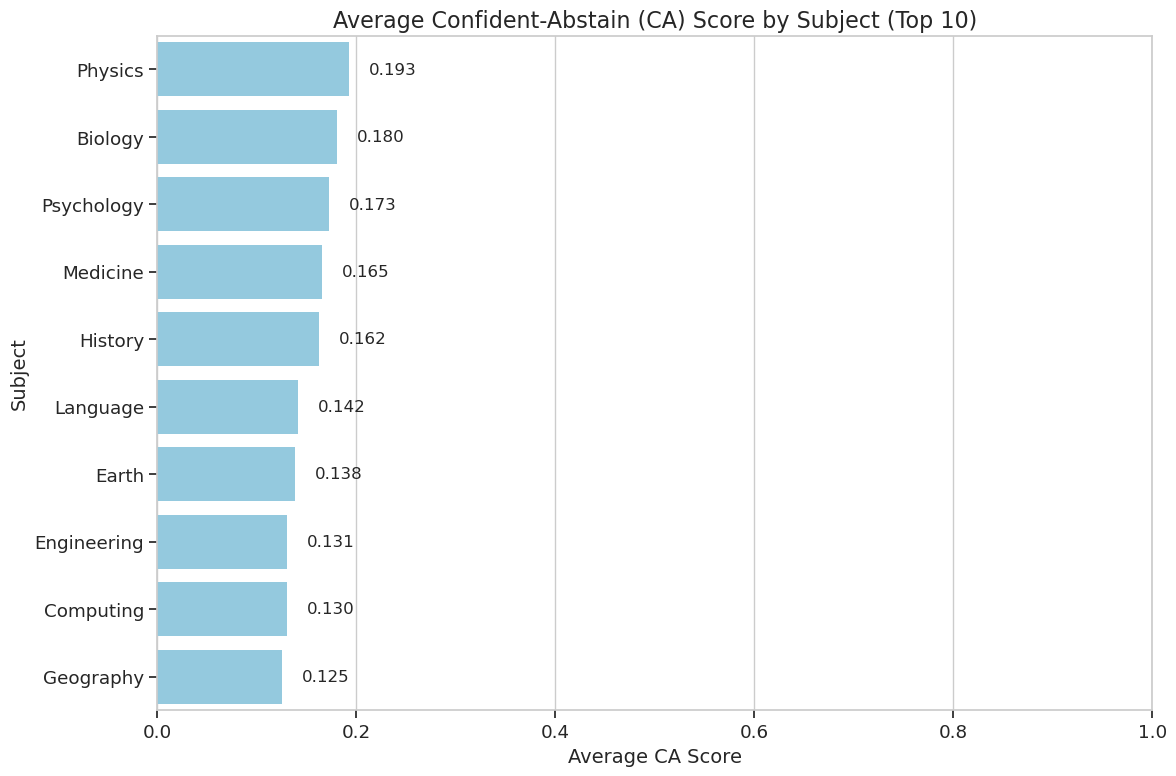

In [16]:
try:
    # Create a horizontal bar plot of CA scores by subject (top 10)
    plt.figure(figsize=(12, 8))

    # Get the top 10 subjects by CA score
    top_subjects = subject_summary.head(10)

    # Plot CA scores
    ax = sns.barplot(y='subject', x='ca_score', data=top_subjects, color='skyblue')

    # Add labels and title
    plt.title('Average Confident-Abstain (CA) Score by Subject (Top 10)', fontsize=16)
    plt.xlabel('Average CA Score', fontsize=14)
    plt.ylabel('Subject', fontsize=14)
    plt.xlim(0, 1)

    # Add value labels
    for i, v in enumerate(top_subjects['ca_score']):
        ax.text(v + 0.02, i, f'{v:.3f}', va='center', fontsize=12)

    plt.tight_layout()
    plt.show()
except NameError:
    print("No metrics data available.")


## Top Examples with Highest HEDGE Scores

Let's examine the top 5 examples with the highest HEDGE scores across all experiments to better understand what types of questions lead to high hedging behavior.


In [17]:
try:
    # Sort the metrics dataframe by hedge_score in descending order
    top_hedge_examples = metrics_df.sort_values('hedge_score', ascending=False).head(5)

    # Display the top examples with relevant information
    for i, (_, row) in enumerate(top_hedge_examples.iterrows(), 1):
        print(f"Example {i} - HEDGE Score: {row['hedge_score']:.4f}, CA Score: {row['ca_score']:.4f}")
        print(f"Question: {row['question']}")
        print(f"Form: {row['form']}, Permutation: {row['permutation']}, Label Type: {row['label_type']}")

        # Get the actual labels used in this experiment
        labels = []
        if row['label_type'] == 'alpha':
            if row['permutation'] == 'p1':
                labels = ["A", "B", "C", "D", "E"]  # Default alpha ordering
            else:
                # For other permutations, we'd need to extract from the data
                # This is a simplified approach
                labels = ["A", "B", "C", "D", "E"]  # Placeholder
        elif row['label_type'] == 'num':
            if row['permutation'] == 'p1':
                labels = ["1", "2", "3", "4", "5"]  # Default numeric ordering
            else:
                # For other permutations, we'd need to extract from the data
                labels = ["1", "2", "3", "4", "5"]  # Placeholder

        # Parse and display probabilities
        try:
            # Convert the JSON string to a dictionary
            import json
            probs = json.loads(row['canonical_probs'])
            print("Answer Probabilities (Canonical):")

            # Calculate Yes/No probabilities for clarity
            p_yes = probs.get("YY", 0) + probs.get("Y", 0)
            p_no = probs.get("N", 0) + probs.get("NN", 0)
            p_idk = probs.get("A", 0)

            # Display individual probabilities
            for label, prob in probs.items():
                print(f"  {label}: {prob:.4f}")

            # Display aggregated probabilities
            print(f"  Total Yes (YY+Y): {p_yes:.4f}")
            print(f"  Total No (N+NN): {p_no:.4f}")
            print(f"  IDK (A): {p_idk:.4f}")

            # Calculate the HEDGE score components
            s = 1.0 - p_idk
            if s > 0:
                r_yes = p_yes / s
                r_no = p_no / s
                print("\nHEDGE Components:")
                print(f"  s (1-p_IDK): {s:.4f}")
                print(f"  r_yes (p_yes/s): {r_yes:.4f}")
                print(f"  r_no (p_no/s): {r_no:.4f}")

                # Calculate entropy
                import numpy as np
                entropy = 0
                if r_yes > 0:
                    entropy -= r_yes * np.log(r_yes)
                if r_no > 0:
                    entropy -= r_no * np.log(r_no)
                normalized_entropy = entropy / np.log(2)
                print(f"  H(r)/log(2): {normalized_entropy:.4f}")
                print(f"  HEDGE = s * H(r)/log(2): {s * normalized_entropy:.4f}")

        except Exception as e:
            print(f"Could not parse probabilities: {e}")

        print(f"Canonical Label: {row['canonical_label']}")
        print(f"Correct Answer: {row['answer']}")
        print("-" * 80)
except NameError:
    print("No metrics data available.")


Example 1 - HEDGE Score: 1.0000, CA Score: 0.0000
Question: Does the process of oxidation involve the loss of electrons?
Form: V4, Permutation: p2, Label Type: num
Answer Probabilities (Canonical):
  YY: 0.5000
  Y: 0.0001
  A: 0.0000
  N: 0.0000
  NN: 0.5000
  Total Yes (YY+Y): 0.5001
  Total No (N+NN): 0.5000
  IDK (A): 0.0000

HEDGE Components:
  s (1-p_IDK): 1.0000
  r_yes (p_yes/s): 0.5001
  r_no (p_no/s): 0.5000
  H(r)/log(2): 1.0000
  HEDGE = s * H(r)/log(2): 0.9999
Canonical Label: YY
Correct Answer: Yes
--------------------------------------------------------------------------------
Example 2 - HEDGE Score: 1.0000, CA Score: 0.0000
Question: Is Mount Everest the highest mountain above sea level on Earth?
Form: V1, Permutation: p3, Label Type: alpha
Answer Probabilities (Canonical):
  YY: 0.5000
  Y: 0.0000
  A: 0.0000
  N: 0.5000
  NN: 0.0005
  Total Yes (YY+Y): 0.5000
  Total No (N+NN): 0.5005
  IDK (A): 0.0000

HEDGE Components:
  s (1-p_IDK): 1.0000
  r_yes (p_yes/s): 0.500

## Top Examples with Highest HEDGE Scores (p1 Permutation Only)

Let's examine the top 5 examples with the highest HEDGE scores specifically from the p1 permutation experiments.


In [18]:
try:
    # Filter for p1 permutation only
    p1_metrics_df = metrics_df[metrics_df['permutation'] == 'p1']

    # Sort the filtered dataframe by hedge_score in descending order
    top_hedge_p1_examples = p1_metrics_df.sort_values('hedge_score', ascending=False).head(5)

    # Display the top examples with relevant information
    for i, (_, row) in enumerate(top_hedge_p1_examples.iterrows(), 1):
        print(f"Example {i} - HEDGE Score: {row['hedge_score']:.4f}, CA Score: {row['ca_score']:.4f}")
        print(f"Question: {row['question']}")
        print(f"Form: {row['form']}, Label Type: {row['label_type']}")

        # Get the actual labels used in this experiment
        labels = []
        if row['label_type'] == 'alpha':
            labels = ["A", "B", "C", "D", "E"]  # Default alpha ordering for p1
        elif row['label_type'] == 'num':
            labels = ["1", "2", "3", "4", "5"]  # Default numeric ordering for p1

        print(f"Labels used: {labels}")
        print("Label mapping: A=IDK, B/D=Probably Yes/No, C/E=Definitely Yes/No")

        # Parse and display probabilities
        try:
            # Convert the JSON string to a dictionary
            import json
            probs = json.loads(row['canonical_probs'])
            print("Answer Probabilities (Canonical):")

            # Calculate Yes/No probabilities for clarity
            p_yes = probs.get("YY", 0) + probs.get("Y", 0)
            p_no = probs.get("N", 0) + probs.get("NN", 0)
            p_idk = probs.get("A", 0)

            # Display individual probabilities
            for label, prob in probs.items():
                print(f"  {label}: {prob:.4f}")

            # Display aggregated probabilities
            print(f"  Total Yes (YY+Y): {p_yes:.4f}")
            print(f"  Total No (N+NN): {p_no:.4f}")
            print(f"  IDK (A): {p_idk:.4f}")

            # Calculate the HEDGE score components
            s = 1.0 - p_idk
            if s > 0:
                r_yes = p_yes / s
                r_no = p_no / s
                print("\nHEDGE Components:")
                print(f"  s (1-p_IDK): {s:.4f}")
                print(f"  r_yes (p_yes/s): {r_yes:.4f}")
                print(f"  r_no (p_no/s): {r_no:.4f}")

                # Calculate entropy
                import numpy as np
                entropy = 0
                if r_yes > 0:
                    entropy -= r_yes * np.log(r_yes)
                if r_no > 0:
                    entropy -= r_no * np.log(r_no)
                normalized_entropy = entropy / np.log(2)
                print(f"  H(r)/log(2): {normalized_entropy:.4f}")
                print(f"  HEDGE = s * H(r)/log(2): {s * normalized_entropy:.4f}")

        except Exception as e:
            print(f"Could not parse probabilities: {e}")

        print(f"Canonical Label: {row['canonical_label']}")
        print(f"Correct Answer: {row['answer']}")
        print("-" * 80)
except NameError:
    print("No metrics data available.")


Example 1 - HEDGE Score: 0.9989, CA Score: 0.0021
Question: Is a preposition a word that shows the relationship between a noun and a verb?
Form: V5, Label Type: alpha
Labels used: ['A', 'B', 'C', 'D', 'E']
Label mapping: A=IDK, B/D=Probably Yes/No, C/E=Definitely Yes/No
Answer Probabilities (Canonical):
  YY: 0.0090
  Y: 0.4941
  A: 0.0011
  N: 0.4941
  NN: 0.0002
  Total Yes (YY+Y): 0.5032
  Total No (N+NN): 0.4944
  IDK (A): 0.0011

HEDGE Components:
  s (1-p_IDK): 0.9989
  r_yes (p_yes/s): 0.5037
  r_no (p_no/s): 0.4949
  H(r)/log(2): 1.0006
  HEDGE = s * H(r)/log(2): 0.9995
Canonical Label: Y
Correct Answer: No
--------------------------------------------------------------------------------
Example 2 - HEDGE Score: 0.9971, CA Score: 0.0001
Question: Is a type system a set of rules that assign a type to program constructs?
Form: V5, Label Type: num
Labels used: ['1', '2', '3', '4', '5']
Label mapping: A=IDK, B/D=Probably Yes/No, C/E=Definitely Yes/No
Answer Probabilities (Canonical)

## Top Examples with Highest CA Scores (p1 Permutation Only)

Let's also examine the top 5 examples with the highest CA scores specifically from the p1 permutation experiments to understand when the model is most confident about abstaining.


In [19]:
try:
    # Filter for p1 permutation only
    p1_metrics_df = metrics_df[metrics_df['permutation'] == 'p1']

    # Sort the filtered dataframe by ca_score in descending order
    top_ca_p1_examples = p1_metrics_df.sort_values('ca_score', ascending=False).head(5)

    # Display the top examples with relevant information
    for i, (_, row) in enumerate(top_ca_p1_examples.iterrows(), 1):
        print(f"Example {i} - CA Score: {row['ca_score']:.4f}, HEDGE Score: {row['hedge_score']:.4f}")
        print(f"Question: {row['question']}")
        print(f"Form: {row['form']}, Label Type: {row['label_type']}")

        # Get the actual labels used in this experiment
        labels = []
        if row['label_type'] == 'alpha':
            labels = ["A", "B", "C", "D", "E"]  # Default alpha ordering for p1
        elif row['label_type'] == 'num':
            labels = ["1", "2", "3", "4", "5"]  # Default numeric ordering for p1

        print(f"Labels used: {labels}")
        print("Label mapping: A=IDK, B/D=Probably Yes/No, C/E=Definitely Yes/No")

        # Parse and display probabilities
        try:
            # Convert the JSON string to a dictionary
            import json
            probs = json.loads(row['canonical_probs'])
            print("Answer Probabilities (Canonical):")

            # Calculate Yes/No probabilities for clarity
            p_yes = probs.get("YY", 0) + probs.get("Y", 0)
            p_no = probs.get("N", 0) + probs.get("NN", 0)
            p_idk = probs.get("A", 0)

            # Display individual probabilities
            for label, prob in probs.items():
                print(f"  {label}: {prob:.4f}")

            # Display aggregated probabilities
            print(f"  Total Yes (YY+Y): {p_yes:.4f}")
            print(f"  Total No (N+NN): {p_no:.4f}")
            print(f"  IDK (A): {p_idk:.4f}")

            # Calculate the CA score components
            q = max(p_yes, p_no)
            print("\nCA Components:")
            print(f"  p_IDK: {p_idk:.4f}")
            print(f"  q (max of p_yes, p_no): {q:.4f}")
            print(f"  CA = p_IDK / (p_IDK + q): {p_idk / (p_idk + q):.4f}")

        except Exception as e:
            print(f"Could not parse probabilities: {e}")

        print(f"Canonical Label: {row['canonical_label']}")
        print(f"Correct Answer: {row['answer']}")
        print("-" * 80)
except NameError:
    print("No metrics data available.")


Example 1 - CA Score: 1.0000, HEDGE Score: 0.0000
Question: Is the Earth's core dynamo self-sustaining indefinitely?
Form: V2, Label Type: num
Labels used: ['1', '2', '3', '4', '5']
Label mapping: A=IDK, B/D=Probably Yes/No, C/E=Definitely Yes/No
Answer Probabilities (Canonical):
  YY: 0.0000
  Y: 0.0000
  A: 1.0000
  N: 0.0000
  NN: 0.0000
  Total Yes (YY+Y): 0.0000
  Total No (N+NN): 0.0000
  IDK (A): 1.0000

CA Components:
  p_IDK: 1.0000
  q (max of p_yes, p_no): 0.0000
  CA = p_IDK / (p_IDK + q): 1.0000
Canonical Label: A
Correct Answer: Unanswerable
--------------------------------------------------------------------------------
Example 2 - CA Score: 1.0000, HEDGE Score: 0.0000
Question: What is dark matter composed of?
Form: V2, Label Type: num
Labels used: ['1', '2', '3', '4', '5']
Label mapping: A=IDK, B/D=Probably Yes/No, C/E=Definitely Yes/No
Answer Probabilities (Canonical):
  YY: 0.0000
  Y: 0.0000
  A: 0.9883
  N: 0.0000
  NN: 0.0000
  Total Yes (YY+Y): 0.0000
  Total No 

## Abstention Direction Analysis

In this section, we'll identify a one-dimensional activation direction in the residual stream that linearly separates abstention from non-abstention at the answer token, focusing on forms V1 and V2 which elicit abstention more reliably.


In [20]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.covariance import ledoit_wolf
from sklearn.metrics import roc_auc_score

# Set random seed for reproducibility
np.random.seed(42)


### 1. Load and Prepare Data

First, we'll load the residual stream data for forms V1 and V2, and filter based on CA scores.


In [26]:
def load_residual_stream_data(forms=['V1', 'V2'], split='train'):
    """
    Load residual stream data for specified forms and split from the by_layer directory.
    
    Args:
        forms: List of forms to include (default: V1 and V2)
        split: Dataset split to use (default: train)
        
    Returns:
        Dictionary mapping layer indices to dictionaries of experiment data
    """
    # Path to the by_layer directory
    by_layer_dir = Path("/home/sergio/projects/MATS-Project/results/by_layer_20250911_112921/by_layer")

    if not by_layer_dir.exists():
        print(f"Directory not found: {by_layer_dir}")
        return {}

    # Initialize data structure
    # {layer_idx: {exp_name: {'vectors': ndarray, 'question_ids': ndarray, 'metadata': dict}}}
    residual_data = {}

    # List all layer directories
    layer_dirs = sorted([d for d in by_layer_dir.glob("layer_*") if d.is_dir()])
    print(f"Found {len(layer_dirs)} layer directories")

    # Process each layer directory
    for layer_dir in layer_dirs:
        layer_idx = int(layer_dir.name.split('_')[1])
        print(f"Processing layer {layer_idx}...")

        # Initialize layer data
        residual_data[layer_idx] = {}

        # Find all experiment files for the specified forms
        for form in forms:
            # Look for .npz files matching the form
            npz_files = list(layer_dir.glob(f"{form}_*_{form}.npz"))

            for npz_file in npz_files:
                # Get the experiment name (e.g., "V1_alpha_p1")
                exp_name = npz_file.stem.replace(f"_{form}", "")

                # Load the npz data
                npz_data = np.load(npz_file)
                question_ids = npz_data['question_ids']
                vectors = npz_data['vectors']

                # Load the corresponding JSON metadata
                json_file = npz_file.with_suffix('.json')
                if json_file.exists():
                    with open(json_file) as f:
                        metadata = json.load(f)
                else:
                    metadata = {}

                # Store the data
                residual_data[layer_idx][exp_name] = {
                    'vectors': vectors,
                    'question_ids': question_ids,
                    'metadata': metadata
                }

                print(f"  Loaded {exp_name} with {len(question_ids)} questions")

    return residual_data

# Load residual stream data for forms V1 and V2
try:
    print("Loading residual stream data from by_layer directory...")
    residual_data = load_residual_stream_data(forms=['V1', 'V2'])

    # Count the total number of experiments across all layers
    total_experiments = sum(len(layer_data) for layer_data in residual_data.values())

    if residual_data:
        print(f"Loaded data for {len(residual_data)} layers with a total of {total_experiments} experiments")

        # Print details for the first layer
        first_layer = min(residual_data.keys())
        first_layer_data = residual_data[first_layer]
        print(f"\nLayer {first_layer} contains {len(first_layer_data)} experiments")

        # Print details for the first experiment in the first layer
        if first_layer_data:
            first_exp = next(iter(first_layer_data))
            exp_data = first_layer_data[first_exp]
            print(f"  Experiment: {first_exp}")
            print(f"  Number of questions: {len(exp_data['question_ids'])}")
            print(f"  Vector dimension: {exp_data['vectors'][0].shape}")

            # Print metadata keys
            if 'metadata' in exp_data and exp_data['metadata']:
                print(f"  Metadata keys: {list(exp_data['metadata'].keys())}")

                # Print question metadata for the first question if available
                if 'question_metadata' in exp_data['metadata']:
                    first_q_id = exp_data['question_ids'][0]
                    if first_q_id in exp_data['metadata']['question_metadata']:
                        q_meta = exp_data['metadata']['question_metadata'][first_q_id]
                        print(f"  First question: {q_meta.get('question', 'N/A')}")
                        print(f"  Subject: {q_meta.get('subject', 'N/A')}")
                        print(f"  Answer: {q_meta.get('answer', 'N/A')}")
    else:
        print("No residual stream data found for forms V1 and V2")
except Exception as e:
    print(f"Error loading residual stream data: {e}")


Loading residual stream data from by_layer directory...
Found 35 layer directories
Processing layer 0...
  Loaded V1_num_p4 with 1050 questions
  Loaded V1_alpha_p4 with 1050 questions
  Loaded V1_alpha_p3 with 1050 questions
  Loaded V1_num_p2 with 1050 questions
  Loaded V1_num_p1 with 1050 questions
  Loaded V1_num_p3 with 1050 questions
  Loaded V1_alpha_p1 with 1050 questions
  Loaded V1_alpha_p5 with 1050 questions
  Loaded V1_alpha_p2 with 1050 questions
  Loaded V1_num_p5 with 1050 questions
  Loaded V2_alpha_p4 with 1050 questions
  Loaded V2_num_p5 with 1050 questions
  Loaded V2_alpha_p3 with 1050 questions
  Loaded V2_num_p3 with 1050 questions
  Loaded V2_alpha_p1 with 1050 questions
  Loaded V2_alpha_p2 with 1050 questions
  Loaded V2_alpha_p5 with 1050 questions
  Loaded V2_num_p1 with 1050 questions
  Loaded V2_num_p2 with 1050 questions
  Loaded V2_num_p4 with 1050 questions
Processing layer 1...
  Loaded V1_num_p4 with 1050 questions
  Loaded V1_alpha_p4 with 1050 que

In [ ]:
# Check vector counts in each layer file
try:
    from pathlib import Path

    import numpy as np

    # Path to the by_layer directory
    by_layer_dir = Path("/home/sergio/projects/MATS-Project/results/by_layer_20250911_112921/by_layer")

    if not by_layer_dir.exists():
        print(f"Directory not found: {by_layer_dir}")
    else:
        # Get all layer directories
        layer_dirs = sorted([d for d in by_layer_dir.glob("layer_*") if d.is_dir()])
        print(f"Found {len(layer_dirs)} layer directories")

        # Track total vectors per layer and by experiment type
        layer_counts = {}
        experiment_counts = {}

        # Process each layer directory
        for layer_dir in layer_dirs:
            layer_idx = int(layer_dir.name.split('_')[1])
            layer_counts[layer_idx] = 0

            # Get all npz files in this layer
            npz_files = list(layer_dir.glob("*.npz"))

            # Process each npz file
            for npz_file in npz_files:
                exp_name = npz_file.stem

                # Load the npz data
                try:
                    data = np.load(npz_file)
                    if 'question_ids' in data and 'vectors' in data:
                        num_vectors = len(data['question_ids'])
                        layer_counts[layer_idx] += num_vectors

                        # Track by experiment type
                        if exp_name not in experiment_counts:
                            experiment_counts[exp_name] = {}
                        experiment_counts[exp_name][layer_idx] = num_vectors
                    else:
                        print(f"  Warning: Missing expected keys in {npz_file}")
                except Exception as e:
                    print(f"  Error loading {npz_file}: {e}")

        # Print summary of vector counts per layer
        print("\nVector counts per layer:")
        for layer_idx in sorted(layer_counts.keys()):
            print(f"Layer {layer_idx}: {layer_counts[layer_idx]} vectors")

        # Check if all layers have the same count
        counts = list(layer_counts.values())
        if len(set(counts)) == 1:
            print(f"\nAll layers have the same number of vectors: {counts[0]}")
        else:
            print(f"\nLayers have different vector counts. Min: {min(counts)}, Max: {max(counts)}")

        # Print counts for V1 and V2 experiments
        print("\nVector counts for V1 and V2 experiments (first layer only):")
        first_layer = min(layer_counts.keys())
        v1v2_experiments = {name: counts[first_layer] for name, counts in experiment_counts.items()
                           if name.startswith('V1') or name.startswith('V2')}

        for exp_name, count in sorted(v1v2_experiments.items()):
            print(f"{exp_name}: {count} vectors")

        # Calculate total for V1 and V2
        v1_total = sum(count for name, count in v1v2_experiments.items() if name.startswith('V1'))
        v2_total = sum(count for name, count in v1v2_experiments.items() if name.startswith('V2'))
        print(f"\nTotal V1: {v1_total} vectors")
        print(f"Total V2: {v2_total} vectors")
        print(f"Combined V1+V2: {v1_total + v2_total} vectors")

except Exception as e:
    print(f"Error checking vector counts: {e}")


In [ ]:
# Check balanced dataset question IDs vs. available vectors
try:
    if 'balanced_dataset' in locals() and by_layer_dir.exists():
        print("Checking balanced dataset against available vectors...")

        # Get all unique question IDs in the balanced dataset
        balanced_ids = balanced_dataset['id'].unique()
        print(f"Balanced dataset has {len(balanced_ids)} unique question IDs")

        # Get all unique question IDs in the first layer
        first_layer = min(layer_counts.keys())
        first_layer_dir = by_layer_dir / f"layer_{first_layer:02d}"

        # Collect all question IDs from all npz files
        all_vector_ids = set()
        v1v2_vector_ids = set()

        for npz_file in first_layer_dir.glob("*.npz"):
            exp_name = npz_file.stem
            data = np.load(npz_file)
            if 'question_ids' in data:
                file_ids = set(data['question_ids'])
                all_vector_ids.update(file_ids)

                # Track V1 and V2 separately
                if exp_name.startswith('V1') or exp_name.startswith('V2'):
                    v1v2_vector_ids.update(file_ids)

        print(f"Found {len(all_vector_ids)} unique question IDs in all vector files")
        print(f"Found {len(v1v2_vector_ids)} unique question IDs in V1/V2 vector files")

        # Check overlap
        overlap = set(balanced_ids).intersection(all_vector_ids)
        print(f"Overlap between balanced dataset and all vectors: {len(overlap)} IDs ({len(overlap)/len(balanced_ids)*100:.1f}%)")

        v1v2_overlap = set(balanced_ids).intersection(v1v2_vector_ids)
        print(f"Overlap between balanced dataset and V1/V2 vectors: {len(v1v2_overlap)} IDs ({len(v1v2_overlap)/len(balanced_ids)*100:.1f}%)")

        # Check missing IDs
        missing_ids = set(balanced_ids) - all_vector_ids
        if missing_ids:
            print(f"\nSample of {min(5, len(missing_ids))} missing IDs from balanced dataset:")
            for id in list(missing_ids)[:5]:
                print(f"  {id}")

        # Check if there's a pattern in the missing IDs
        if missing_ids:
            # Get form and label_type for missing IDs
            missing_info = balanced_dataset[balanced_dataset['id'].isin(missing_ids)][['id', 'form', 'label_type']]
            missing_by_form = missing_info['form'].value_counts()
            missing_by_label = missing_info['label_type'].value_counts()

            print("\nMissing IDs by form:")
            for form, count in missing_by_form.items():
                print(f"  {form}: {count} IDs")

            print("\nMissing IDs by label type:")
            for label, count in missing_by_label.items():
                print(f"  {label}: {count} IDs")
    else:
        print("Balanced dataset or by_layer directory not available")
except Exception as e:
    print(f"Error checking ID overlap: {e}")


In [ ]:
# Check for experiment-specific issues
try:
    if 'balanced_dataset' in locals() and 'experiment_counts' in locals():
        print("Checking for experiment-specific issues...")

        # Get counts of examples in balanced dataset by form and label_type
        balanced_counts = balanced_dataset.groupby(['form', 'label_type']).size().reset_index(name='count')
        print("\nBalanced dataset counts by form and label_type:")
        print(balanced_counts)

        # Compare with vector counts
        print("\nVector counts by experiment (first layer):")
        first_layer = min(layer_counts.keys())

        for form in balanced_dataset['form'].unique():
            for label_type in balanced_dataset['label_type'].unique():
                # Find matching experiments
                exp_key = f"{form}_{label_type}"
                matching_exps = [name for name in experiment_counts.keys() if name.startswith(exp_key)]

                # Get total vectors for this form/label_type
                total_vectors = sum(experiment_counts[name][first_layer] for name in matching_exps if name in experiment_counts)

                # Get balanced count
                balanced_count = balanced_counts[(balanced_counts['form'] == form) &
                                               (balanced_counts['label_type'] == label_type)]['count'].values

                if len(balanced_count) > 0:
                    print(f"{form}, {label_type}: {total_vectors} vectors, {balanced_count[0]} balanced examples")
                else:
                    print(f"{form}, {label_type}: {total_vectors} vectors, 0 balanced examples")

        # Check for permutation issues
        if 'permutation' in balanced_dataset.columns:
            print("\nChecking permutation distribution:")
            perm_counts = balanced_dataset.groupby(['form', 'label_type', 'permutation']).size().reset_index(name='count')
            print(perm_counts)
    else:
        print("Required data not available")
except Exception as e:
    print(f"Error in experiment-specific check: {e}")


In [ ]:
# Analyze the matching logic in extract_residual_vectors
try:
    if 'balanced_dataset' in locals() and by_layer_dir.exists():
        print("Analyzing the matching logic...")

        # Sample a few examples from the balanced dataset
        sample_rows = balanced_dataset.sample(min(5, len(balanced_dataset)))

        print("\nSample rows from balanced dataset:")
        for _, row in sample_rows.iterrows():
            q_id = row['id']
            form = row['form']
            label_type = row['label_type']
            ca_score = row['ca_score']
            class_label = row['class']
            print(f"ID: {q_id}, Form: {form}, Label Type: {label_type}, CA Score: {ca_score:.4f}, Class: {class_label}")

            # Check if this ID exists in the vector files
            first_layer = min(layer_counts.keys())
            first_layer_dir = by_layer_dir / f"layer_{first_layer:02d}"

            # Look for matching experiment files
            exp_pattern = f"{form}_{label_type}_*"
            matching_files = list(first_layer_dir.glob(f"{exp_pattern}.npz"))

            if matching_files:
                print(f"  Found {len(matching_files)} matching experiment files:")
                for file_path in matching_files:
                    exp_name = file_path.stem
                    data = np.load(file_path)
                    if 'question_ids' in data:
                        question_ids = data['question_ids']
                        if q_id in question_ids:
                            idx = np.where(question_ids == q_id)[0][0]
                            print(f"    Found in {exp_name} at index {idx}")
                        else:
                            print(f"    Not found in {exp_name}")
                    else:
                        print(f"    No question_ids in {exp_name}")
            else:
                print(f"  No matching experiment files found for pattern: {exp_pattern}")

            print("  ---")

        # Check a specific experiment file
        if experiment_counts:
            # Pick a V1 or V2 experiment
            v1v2_exps = [name for name in experiment_counts.keys() if name.startswith('V1') or name.startswith('V2')]
            if v1v2_exps:
                sample_exp = v1v2_exps[0]
                sample_file = first_layer_dir / f"{sample_exp}.npz"

                if sample_file.exists():
                    print(f"\nExamining sample experiment file: {sample_exp}")
                    data = np.load(sample_file)
                    if 'question_ids' in data:
                        question_ids = data['question_ids']
                        print(f"  Contains {len(question_ids)} question IDs")
                        print(f"  First 5 IDs: {', '.join(question_ids[:5])}")

                        # Extract form and label_type from experiment name
                        parts = sample_exp.split("_")
                        if len(parts) >= 2:
                            form = parts[0]
                            label_type = parts[1]

                            # Check how many of these IDs are in the balanced dataset
                            matching_rows = balanced_dataset[
                                (balanced_dataset['id'].isin(question_ids)) &
                                (balanced_dataset['form'] == form) &
                                (balanced_dataset['label_type'] == label_type)
                            ]

                            print(f"  {len(matching_rows)} IDs from this file match the balanced dataset")
                            if len(matching_rows) < len(question_ids):
                                print(f"  {len(question_ids) - len(matching_rows)} IDs don't match")

                                # Check why they don't match
                                sample_missing = set(question_ids) - set(matching_rows['id'])
                                if sample_missing:
                                    print("\n  Sample of non-matching IDs:")
                                    for id in list(sample_missing)[:3]:
                                        # Check if ID exists in balanced dataset at all
                                        id_rows = balanced_dataset[balanced_dataset['id'] == id]
                                        if len(id_rows) > 0:
                                            id_row = id_rows.iloc[0]
                                            print(f"    ID {id} exists in balanced dataset with form={id_row['form']}, label_type={id_row['label_type']}")
                                        else:
                                            print(f"    ID {id} not found in balanced dataset at all")
                    else:
                        print("  No question_ids found in file")
    else:
        print("Required data not available")
except Exception as e:
    print(f"Error analyzing matching logic: {e}")


In [ ]:
# Modified extraction cell that checks for saved data first
try:
    # First, check if saved data already exists
    import pickle
    from datetime import datetime
    from pathlib import Path

    # Define the save directory
    save_dir = Path("./results/abstention_direction")
    saved_data_exists = False

    if save_dir.exists():
        # Look for saved residual vector files
        saved_files = list(save_dir.glob("residual_vectors_*.pkl"))

        if saved_files:
            # Sort by modification time (most recent first)
            latest_file = max(saved_files, key=lambda f: f.stat().st_mtime)

            print(f"Found saved residual vectors: {latest_file}")
            print(f"Last modified: {datetime.fromtimestamp(latest_file.stat().st_mtime)}")

            # Ask if we want to use the saved data
            use_saved_data = True  # Set to True to skip extraction if saved data exists

            if use_saved_data:
                print("Using saved data instead of re-extracting vectors...")
                with open(latest_file, 'rb') as f:
                    saved_data = pickle.load(f)

                # Extract the data
                if 'residual_vectors' in saved_data and 'residual_vectors_by_layer' in saved_data:
                    residual_vectors = saved_data['residual_vectors']
                    residual_vectors_by_layer = saved_data['residual_vectors_by_layer']

                    # Print some info about the loaded data
                    num_layers_with_data = len(residual_vectors_by_layer)
                    first_layer = min(residual_vectors_by_layer.keys())
                    first_layer_data = residual_vectors_by_layer[first_layer]

                    print(f"Loaded data for {num_layers_with_data} layers")
                    print(f"\nLayer {first_layer} details:")
                    print(f"  Positive examples: {first_layer_data['positive'].shape}")
                    print(f"  Negative examples: {first_layer_data['negative'].shape}")
                    print(f"  Vector dimension: {first_layer_data['positive'][0].shape}")

                    print("\nReady for Fisher LDA analysis")
                    saved_data_exists = True
                else:
                    print("Saved file does not contain the expected data, will extract vectors...")
            else:
                print("Will extract vectors despite saved data being available...")

    # Only extract vectors if we don't have saved data
    if not saved_data_exists:
        # Check if we have residual data and balanced dataset
        if 'residual_data' in locals() and 'balanced_dataset' in locals():
            print("Extracting residual vectors from the actual data...")

            # Extract vectors for all layers
            residual_vectors_by_layer = extract_residual_vectors(balanced_dataset, residual_data)

            # Count the number of layers with data
            num_layers_with_data = len(residual_vectors_by_layer)

            if num_layers_with_data > 0:
                print(f"Successfully extracted vectors for {num_layers_with_data} layers")

                # Print details for the first layer
                first_layer = min(residual_vectors_by_layer.keys())
                first_layer_data = residual_vectors_by_layer[first_layer]

                print(f"\nLayer {first_layer} details:")
                print(f"  Positive examples: {first_layer_data['positive'].shape}")
                print(f"  Negative examples: {first_layer_data['negative'].shape}")
                print(f"  Vector dimension: {first_layer_data['positive'][0].shape}")

                # Prepare the residual_vectors dictionary for the rest of the notebook
                residual_vectors = {
                    'positive': {layer: data['positive'] for layer, data in residual_vectors_by_layer.items()},
                    'negative': {layer: data['negative'] for layer, data in residual_vectors_by_layer.items()}
                }

                print("\nReady for Fisher LDA analysis")
            else:
                print("No matching vectors found in the residual data")
        else:
            print("Residual data or balanced dataset not available")
except Exception as e:
    print(f"Error extracting residual vectors: {e}")


In [27]:
try:
    # Filter metrics_df for forms V1 and V2 and split 'train'
    v1v2_metrics = metrics_df[(metrics_df['form'].isin(['V1', 'V2'])) &
                             (metrics_df['split'] == 'train')]

    print(f"Found {len(v1v2_metrics)} examples for forms V1 and V2 in the train split")

    # Calculate the 25% and 75% quantiles of CA scores
    q25 = v1v2_metrics['ca_score'].quantile(0.25)
    q75 = v1v2_metrics['ca_score'].quantile(0.75)

    print(f"CA score quantiles - 25%: {q25:.4f}, 75%: {q75:.4f}")

    # Create positive and negative classes based on CA scores
    positive_class = v1v2_metrics[v1v2_metrics['ca_score'] >= q75]
    negative_class = v1v2_metrics[v1v2_metrics['ca_score'] <= q25]

    print(f"Positive class (high CA): {len(positive_class)} examples")
    print(f"Negative class (low CA): {len(negative_class)} examples")

    # Check distribution across subject areas and prompt forms
    print("\nDistribution across forms:")
    print(pd.concat([
        positive_class['form'].value_counts().rename('Positive'),
        negative_class['form'].value_counts().rename('Negative')
    ], axis=1))

    print("\nDistribution across subjects (top 5):")
    print(pd.concat([
        positive_class['subject'].value_counts().head().rename('Positive'),
        negative_class['subject'].value_counts().head().rename('Negative')
    ], axis=1))

    print("\nDistribution across label types:")
    print(pd.concat([
        positive_class['label_type'].value_counts().rename('Positive'),
        negative_class['label_type'].value_counts().rename('Negative')
    ], axis=1))

except NameError:
    print("metrics_df not available. Please run the previous cells to load the metrics data.")


Found 41810 examples for forms V1 and V2 in the train split
CA score quantiles - 25%: 0.0006, 75%: 0.5312
Positive class (high CA): 10504 examples
Negative class (low CA): 10650 examples

Distribution across forms:
      Positive  Negative
form                    
V1        6753      5992
V2        3751      4658

Distribution across subjects (top 5):
             Positive  Negative
subject                        
Biology        1026.0       NaN
Medicine        975.0       NaN
Physics         973.0     796.0
Psychology      970.0       NaN
Earth           815.0     871.0
Engineering       NaN    1060.0
Chemistry         NaN     958.0
Computing         NaN     888.0

Distribution across label types:
            Positive  Negative
label_type                    
num             5329      4259
alpha           5175      6391


### Helper Functions for Residual Stream Analysis

Below are the helper functions used for extracting and analyzing residual stream vectors with auto-save functionality to prevent data loss.


In [ ]:
def extract_residual_vectors(dataset, residual_data, save_incremental=True, save_frequency=3):
    """
    Extract residual stream vectors for examples in the dataset.
    
    Args:
        dataset: DataFrame containing examples with question IDs, form, and label_type
        residual_data: Dictionary mapping layer indices to dictionaries of experiment data
        save_incremental: Whether to save data after processing layers (default: True)
        save_frequency: How often to save (every N layers) (default: 3)
        
    Returns:
        Dictionary mapping layer indices to matrices H_pos and H_neg
    """
    import pickle
    from datetime import datetime
    from pathlib import Path

    # Create save directory if saving incrementally
    if save_incremental:
        save_dir = Path("./results/abstention_direction")
        save_dir.mkdir(parents=True, exist_ok=True)
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Initialize dictionaries to store residual vectors for each layer
    result = {}

    # Get sorted layer indices for consistent processing
    layer_indices = sorted(residual_data.keys())
    total_layers = len(layer_indices)
    print(f"Processing {total_layers} layers...")

    # Process each layer
    for i, layer_idx in enumerate(layer_indices):
        layer_data = residual_data[layer_idx]
        print(f"Extracting vectors for layer {layer_idx} ({i+1}/{total_layers})...")

        # Initialize positive and negative vectors for this layer
        H_pos = []  # For high CA examples (class 1)
        H_neg = []  # For low CA examples (class 0)
        pos_question_ids = []
        neg_question_ids = []

        # Process each experiment in this layer
        for exp_name, exp_data in layer_data.items():
            # Extract form and label_type from experiment name
            parts = exp_name.split("_")
            if len(parts) < 2:
                continue

            form = parts[0]
            label_type = parts[1]

            # Get question IDs and vectors
            question_ids = exp_data['question_ids']
            vectors = exp_data['vectors']

            # Match with our dataset
            for j, q_id in enumerate(question_ids):
                # Find matching rows in our dataset
                matching_rows = dataset[(dataset['id'] == q_id) &
                                       (dataset['form'] == form) &
                                       (dataset['label_type'] == label_type)]

                if len(matching_rows) > 0:
                    # Get the class label (1 for positive, 0 for negative)
                    class_label = matching_rows['class'].values[0]

                    # Get the vector for this question
                    vector = vectors[j]

                    # Add to the appropriate list
                    if class_label == 1:
                        H_pos.append(vector)
                        pos_question_ids.append(q_id)
                    else:
                        H_neg.append(vector)
                        neg_question_ids.append(q_id)

        # Convert lists to numpy arrays if they're not empty
        if H_pos and H_neg:
            result[layer_idx] = {
                'positive': np.array(H_pos),
                'negative': np.array(H_neg),
                'pos_question_ids': pos_question_ids,
                'neg_question_ids': neg_question_ids
            }
            print(f"  Layer {layer_idx}: {len(H_pos)} positive examples, {len(H_neg)} negative examples")

            # Save incrementally after processing layers
            if save_incremental and (i+1) % save_frequency == 0:
                # Prepare the partial residual_vectors dictionary
                partial_vectors = {
                    'positive': {l: data['positive'] for l, data in result.items()},
                    'negative': {l: data['negative'] for l, data in result.items()}
                }

                # Save to file with layer info
                save_path = save_dir / f"residual_vectors_{timestamp}_through_layer_{layer_idx}.pkl"

                save_data = {
                    'residual_vectors': partial_vectors,
                    'residual_vectors_by_layer': result,
                    'timestamp': timestamp,
                    'completed_layers': list(result.keys()),
                    'forms': dataset['form'].unique().tolist() if 'form' in dataset.columns else ['V1', 'V2']
                }

                try:
                    with open(save_path, 'wb') as f:
                        pickle.dump(save_data, f)
                    print(f"  Saved progress through layer {layer_idx} to {save_path}")
                except Exception as e:
                    print(f"  Error saving progress: {e}")

    # Save final complete result
    if save_incremental and result:
        # Prepare the final residual_vectors dictionary
        final_vectors = {
            'positive': {l: data['positive'] for l, data in result.items()},
            'negative': {l: data['negative'] for l, data in result.items()}
        }

        # Save to file
        final_save_path = save_dir / f"residual_vectors_{timestamp}_complete.pkl"

        final_save_data = {
            'residual_vectors': final_vectors,
            'residual_vectors_by_layer': result,
            'timestamp': timestamp,
            'completed_layers': list(result.keys()),
            'forms': dataset['form'].unique().tolist() if 'form' in dataset.columns else ['V1', 'V2']
        }

        try:
            with open(final_save_path, 'wb') as f:
                pickle.dump(final_save_data, f)
            print(f"Saved complete results to {final_save_path}")
        except Exception as e:
            print(f"Error saving final results: {e}")

    return result


In [ ]:
def load_or_extract_residual_vectors(dataset=None, residual_data=None):
    """
    Load saved residual vectors if available, or extract them if not.
    
    Args:
        dataset: DataFrame containing examples with question IDs, form, and label_type
        residual_data: Dictionary mapping layer indices to dictionaries of experiment data
        
    Returns:
        Tuple of (residual_vectors, residual_vectors_by_layer)
    """
    import pickle
    from datetime import datetime
    from pathlib import Path

    # Define the save directory
    save_dir = Path("./results/abstention_direction")
    saved_data_exists = False

    if save_dir.exists():
        # Look for saved residual vector files
        saved_files = list(save_dir.glob("residual_vectors_*.pkl"))

        if saved_files:
            # Sort by modification time (most recent first)
            latest_file = max(saved_files, key=lambda f: f.stat().st_mtime)

            print(f"Found saved residual vectors: {latest_file}")
            print(f"Last modified: {datetime.fromtimestamp(latest_file.stat().st_mtime)}")

            # Use the saved data
            use_saved_data = True  # Set to True to skip extraction if saved data exists

            if use_saved_data:
                with open(latest_file, 'rb') as f:
                    saved_data = pickle.load(f)

                # Check if the saved data has the expected structure
                if 'residual_vectors' in saved_data and 'residual_vectors_by_layer' in saved_data:
                    # Load the data into the appropriate variables
                    residual_vectors = saved_data['residual_vectors']
                    residual_vectors_by_layer = saved_data['residual_vectors_by_layer']

                    # Print some information about the loaded data
                    num_layers = len(residual_vectors_by_layer)
                    layer_indices = sorted(residual_vectors_by_layer.keys())

                    print(f"Successfully loaded data for {num_layers} layers: {layer_indices}")

                    if layer_indices:
                        first_layer = layer_indices[0]
                        first_layer_data = residual_vectors_by_layer[first_layer]

                        print(f"\nLayer {first_layer} details:")
                        print(f"  Positive examples: {first_layer_data['positive'].shape}")
                        print(f"  Negative examples: {first_layer_data['negative'].shape}")
                        print(f"  Vector dimension: {first_layer_data['positive'][0].shape}")

                    print("\nReady for Fisher LDA analysis")
                    saved_data_exists = True
                    return residual_vectors, residual_vectors_by_layer
                else:
                    print("Saved file does not contain the expected data structure")

    # If no saved data exists or couldn't be loaded, extract the vectors
    if not saved_data_exists:
        # Check if we have residual data and balanced dataset
        if dataset is not None and residual_data is not None:
            print("No usable saved data found. Extracting residual vectors from the actual data...")

            # Extract vectors for all layers with incremental saving
            residual_vectors_by_layer = extract_residual_vectors(dataset, residual_data, save_incremental=True, save_frequency=3)

            # Count the number of layers with data
            num_layers_with_data = len(residual_vectors_by_layer)

            if num_layers_with_data > 0:
                print(f"Successfully extracted vectors for {num_layers_with_data} layers")

                # Print details for the first layer
                first_layer = min(residual_vectors_by_layer.keys())
                first_layer_data = residual_vectors_by_layer[first_layer]

                print(f"\nLayer {first_layer} details:")
                print(f"  Positive examples: {first_layer_data['positive'].shape}")
                print(f"  Negative examples: {first_layer_data['negative'].shape}")
                print(f"  Vector dimension: {first_layer_data['positive'][0].shape}")

                # Prepare the residual_vectors dictionary for the rest of the notebook
                residual_vectors = {
                    'positive': {layer: data['positive'] for layer, data in residual_vectors_by_layer.items()},
                    'negative': {layer: data['negative'] for layer, data in residual_vectors_by_layer.items()}
                }

                print("\nReady for Fisher LDA analysis")
                return residual_vectors, residual_vectors_by_layer
            else:
                print("No matching vectors found in the residual data")
                return None, None
        else:
            print("Residual data or balanced dataset not available")
            return None, None

    return None, None


### Usage Example

Here's how to use the functions above to load or extract residual vectors:

```python
# If you have residual_data and balanced_dataset:
residual_vectors, residual_vectors_by_layer = load_or_extract_residual_vectors(
    dataset=balanced_dataset, 
    residual_data=residual_data
)

# This will:
# 1. Check for previously saved data and load it if available
# 2. Extract vectors from scratch if no saved data exists
# 3. Save progress incrementally during extraction to prevent data loss
```


### 3. Balance the Dataset

We'll balance the positive and negative classes across subject areas and prompt labels to avoid confounds.


In [28]:
def balance_dataset(positive_df, negative_df, balance_cols=['subject', 'form', 'label_type']):
    """
    Balance positive and negative classes across specified columns.
    
    Args:
        positive_df: DataFrame containing positive class examples
        negative_df: DataFrame containing negative class examples
        balance_cols: List of columns to balance across
        
    Returns:
        Tuple of (balanced_positive_df, balanced_negative_df)
    """
    # Create a combined groupby across all balance columns
    pos_counts = positive_df.groupby(balance_cols).size()
    neg_counts = negative_df.groupby(balance_cols).size()

    # Find common groups
    common_groups = set(pos_counts.index).intersection(set(neg_counts.index))

    # Initialize empty DataFrames for balanced data
    balanced_pos = pd.DataFrame()
    balanced_neg = pd.DataFrame()

    # For each common group, take the minimum count from both classes
    for group in common_groups:
        # Convert group to tuple if it's not already
        group_tuple = group if isinstance(group, tuple) else (group,)

        # Create filter conditions
        filter_conditions = {col: val for col, val in zip(balance_cols, group_tuple)}

        # Filter the DataFrames
        pos_group = positive_df
        neg_group = negative_df

        for col, val in filter_conditions.items():
            pos_group = pos_group[pos_group[col] == val]
            neg_group = neg_group[neg_group[col] == val]

        # Get counts
        pos_count = len(pos_group)
        neg_count = len(neg_group)
        min_count = min(pos_count, neg_count)

        if min_count > 0:
            # Sample min_count examples from each group
            balanced_pos = pd.concat([balanced_pos, pos_group.sample(min_count, random_state=42)])
            balanced_neg = pd.concat([balanced_neg, neg_group.sample(min_count, random_state=42)])

    return balanced_pos, balanced_neg

try:
    # Balance the dataset
    balanced_positive, balanced_negative = balance_dataset(positive_class, negative_class)

    print(f"Balanced positive class: {len(balanced_positive)} examples")
    print(f"Balanced negative class: {len(balanced_negative)} examples")

    # Check the balanced distribution
    print("\nBalanced distribution across forms:")
    print(pd.concat([
        balanced_positive['form'].value_counts().rename('Positive'),
        balanced_negative['form'].value_counts().rename('Negative')
    ], axis=1))

    print("\nBalanced distribution across label types:")
    print(pd.concat([
        balanced_positive['label_type'].value_counts().rename('Positive'),
        balanced_negative['label_type'].value_counts().rename('Negative')
    ], axis=1))

    # Create a combined dataset with labels
    balanced_positive['class'] = 1  # High CA (abstention)
    balanced_negative['class'] = 0  # Low CA (non-abstention)

    balanced_dataset = pd.concat([balanced_positive, balanced_negative])
    print(f"\nFinal balanced dataset: {len(balanced_dataset)} examples")

    # Shuffle the dataset
    balanced_dataset = balanced_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

except NameError:
    print("positive_class or negative_class not available. Please run the previous cells.")


Balanced positive class: 8598 examples
Balanced negative class: 8598 examples

Balanced distribution across forms:
      Positive  Negative
form                    
V1        5310      5310
V2        3288      3288

Balanced distribution across label types:
            Positive  Negative
label_type                    
alpha           4815      4815
num             3783      3783

Final balanced dataset: 17196 examples


### 4. Extract Residual Stream Vectors

Now we'll extract the residual stream vectors for each example in our balanced dataset.


In [29]:
def extract_residual_vectors(dataset, residual_data):
    """
    Extract residual stream vectors for examples in the dataset.
    
    Args:
        dataset: DataFrame containing examples with question IDs, form, and label_type
        residual_data: Dictionary mapping layer indices to dictionaries of experiment data
        
    Returns:
        Dictionary mapping layer indices to matrices H_pos and H_neg
    """
    # Initialize dictionaries to store residual vectors for each layer
    result = {}

    # Process each layer
    for layer_idx, layer_data in residual_data.items():
        print(f"Extracting vectors for layer {layer_idx}...")

        # Initialize positive and negative vectors for this layer
        H_pos = []  # For high CA examples (class 1)
        H_neg = []  # For low CA examples (class 0)
        pos_question_ids = []
        neg_question_ids = []

        # Process each experiment in this layer
        for exp_name, exp_data in layer_data.items():
            # Extract form and label_type from experiment name
            parts = exp_name.split("_")
            if len(parts) < 2:
                continue

            form = parts[0]
            label_type = parts[1]

            # Get question IDs and vectors
            question_ids = exp_data['question_ids']
            vectors = exp_data['vectors']

            # Match with our dataset
            for i, q_id in enumerate(question_ids):
                # Find matching rows in our dataset
                matching_rows = dataset[(dataset['id'] == q_id) &
                                       (dataset['form'] == form) &
                                       (dataset['label_type'] == label_type)]

                if len(matching_rows) > 0:
                    # Get the class label (1 for positive, 0 for negative)
                    class_label = matching_rows['class'].values[0]

                    # Get the vector for this question
                    vector = vectors[i]

                    # Add to the appropriate list
                    if class_label == 1:
                        H_pos.append(vector)
                        pos_question_ids.append(q_id)
                    else:
                        H_neg.append(vector)
                        neg_question_ids.append(q_id)

        # Convert lists to numpy arrays if they're not empty
        if H_pos and H_neg:
            result[layer_idx] = {
                'positive': np.array(H_pos),
                'negative': np.array(H_neg),
                'pos_question_ids': pos_question_ids,
                'neg_question_ids': neg_question_ids
            }
            print(f"  Layer {layer_idx}: {len(H_pos)} positive examples, {len(H_neg)} negative examples")

    return result

try:
    # Check if we have residual data and balanced dataset
    if 'residual_data' in locals() and 'balanced_dataset' in locals():
        print("Extracting residual vectors from the actual data...")

        # Extract vectors for all layers
        residual_vectors_by_layer = extract_residual_vectors(balanced_dataset, residual_data)

        # Count the number of layers with data
        num_layers_with_data = len(residual_vectors_by_layer)

        if num_layers_with_data > 0:
            print(f"Successfully extracted vectors for {num_layers_with_data} layers")

            # Print details for the first layer
            first_layer = min(residual_vectors_by_layer.keys())
            first_layer_data = residual_vectors_by_layer[first_layer]

            print(f"\nLayer {first_layer} details:")
            print(f"  Positive examples: {first_layer_data['positive'].shape}")
            print(f"  Negative examples: {first_layer_data['negative'].shape}")
            print(f"  Vector dimension: {first_layer_data['positive'][0].shape}")

            # Prepare the residual_vectors dictionary for the rest of the notebook
            residual_vectors = {
                'positive': {layer: data['positive'] for layer, data in residual_vectors_by_layer.items()},
                'negative': {layer: data['negative'] for layer, data in residual_vectors_by_layer.items()}
            }

            print("\nReady for Fisher LDA analysis")
        else:
            print("No matching vectors found in the residual data")
    else:
        print("Residual data or balanced dataset not available")
except Exception as e:
    print(f"Error extracting residual vectors: {e}")


Extracting residual vectors from the actual data...
Extracting vectors for layer 0...
  Layer 0: 7255 positive examples, 7250 negative examples
Extracting vectors for layer 1...
  Layer 1: 7255 positive examples, 7250 negative examples
Extracting vectors for layer 2...
  Layer 2: 7255 positive examples, 7250 negative examples
Extracting vectors for layer 3...
  Layer 3: 7255 positive examples, 7250 negative examples
Extracting vectors for layer 4...
  Layer 4: 7255 positive examples, 7250 negative examples
Extracting vectors for layer 5...
  Layer 5: 7255 positive examples, 7250 negative examples
Extracting vectors for layer 6...
  Layer 6: 7255 positive examples, 7250 negative examples
Extracting vectors for layer 7...
  Layer 7: 7255 positive examples, 7250 negative examples
Extracting vectors for layer 8...
  Layer 8: 7255 positive examples, 7250 negative examples
Extracting vectors for layer 9...
  Layer 9: 7255 positive examples, 7250 negative examples
Extracting vectors for layer

: 

In [ ]:
# Save the extracted residual vectors to avoid recomputation
try:
    if 'residual_vectors_by_layer' in locals() and 'residual_vectors' in locals():
        import pickle
        from datetime import datetime

        # Create a timestamp for the filename
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

        # Create save directory if it doesn't exist
        save_dir = Path("./results/abstention_direction")
        save_dir.mkdir(parents=True, exist_ok=True)

        # Save the residual vectors
        save_path = save_dir / f"residual_vectors_{timestamp}.pkl"

        # We'll save a dictionary with all the important data
        save_data = {
            'residual_vectors': residual_vectors,
            'residual_vectors_by_layer': residual_vectors_by_layer,
            'balanced_dataset': balanced_dataset if 'balanced_dataset' in locals() else None,
            'timestamp': timestamp,
            'forms': ['V1', 'V2']  # The forms we used
        }

        with open(save_path, 'wb') as f:
            pickle.dump(save_data, f)

        print(f"Saved residual vectors to {save_path}")
        print("You can load this data in future sessions with:")
        print(f"with open('{save_path}', 'rb') as f:")
        print("    saved_data = pickle.load(f)")
        print("    residual_vectors = saved_data['residual_vectors']")
        print("    residual_vectors_by_layer = saved_data['residual_vectors_by_layer']")
    else:
        print("No residual vectors available to save")
except Exception as e:
    print(f"Error saving residual vectors: {e}")


In [ ]:
# Load previously saved residual vectors (if available)
try:
    import pickle

    # Find the most recent saved file
    save_dir = Path("./results/abstention_direction")
    if save_dir.exists():
        saved_files = list(save_dir.glob("residual_vectors_*.pkl"))

        if saved_files:
            # Sort by modification time (most recent first)
            latest_file = max(saved_files, key=lambda f: f.stat().st_mtime)

            print(f"Found saved residual vectors: {latest_file}")
            print(f"Last modified: {datetime.fromtimestamp(latest_file.stat().st_mtime)}")

            # Ask if we want to load it
            load_saved = True  # In a notebook, you'd typically set this manually

            if load_saved:
                with open(latest_file, 'rb') as f:
                    saved_data = pickle.load(f)

                # Extract the data
                if 'residual_vectors' in saved_data and 'residual_vectors_by_layer' in saved_data:
                    residual_vectors = saved_data['residual_vectors']
                    residual_vectors_by_layer = saved_data['residual_vectors_by_layer']

                    # Print some info about the loaded data
                    num_layers = len(residual_vectors_by_layer)
                    first_layer = min(residual_vectors_by_layer.keys())
                    first_layer_data = residual_vectors_by_layer[first_layer]

                    print(f"Loaded data for {num_layers} layers")
                    print(f"Layer {first_layer} has {len(first_layer_data['positive'])} positive and {len(first_layer_data['negative'])} negative examples")
                    print("Ready to continue with Fisher LDA analysis")
                else:
                    print("Saved file does not contain the expected data")
        else:
            print("No saved residual vectors found")
    else:
        print("No save directory found")
except Exception as e:
    print(f"Error loading saved residual vectors: {e}")


### 5. Implement Fisher LDA with Shrinkage

Now we'll implement the whitened mean difference (Fisher LDA with shrinkage) to find the abstention direction for each layer.


In [ ]:
def compute_fisher_lda_direction(H_pos, H_neg, lambda_=0.5, alpha=1.0):
    """
    Compute the Fisher LDA direction with shrinkage.
    
    Args:
        H_pos: Matrix of positive class examples (n_pos x d)
        H_neg: Matrix of negative class examples (n_neg x d)
        lambda_: Shrinkage coefficient (default: 0.5)
        alpha: Identity scaling factor (default: 1.0)
        
    Returns:
        Normalized direction vector v
    """
    # Compute means
    mu_pos = np.mean(H_pos, axis=0)
    mu_neg = np.mean(H_neg, axis=0)

    # Compute mean difference
    mean_diff = mu_pos - mu_neg

    # Compute pooled covariance
    n_pos = H_pos.shape[0]
    n_neg = H_neg.shape[0]
    n_total = n_pos + n_neg

    # Center the data
    H_pos_centered = H_pos - mu_pos
    H_neg_centered = H_neg - mu_neg

    # Compute individual covariances
    cov_pos = np.dot(H_pos_centered.T, H_pos_centered) / n_pos
    cov_neg = np.dot(H_neg_centered.T, H_neg_centered) / n_neg

    # Compute pooled covariance
    cov_pooled = ((n_pos * cov_pos) + (n_neg * cov_neg)) / n_total

    # Apply shrinkage
    d = cov_pooled.shape[0]  # Dimensionality

    # Use Ledoit-Wolf shrinkage if available
    try:
        # Combine the data for Ledoit-Wolf estimation
        X_combined = np.vstack([H_pos, H_neg])

        # Estimate the optimal shrinkage using Ledoit-Wolf
        shrinkage_cov, lambda_estimated = ledoit_wolf(X_combined)

        # Use the estimated lambda if requested
        if lambda_ < 0:
            print(f"  Using Ledoit-Wolf estimated lambda: {lambda_estimated:.4f}")
            lambda_ = lambda_estimated
    except Exception as e:
        print(f"  Ledoit-Wolf estimation failed: {e}. Using provided lambda: {lambda_}")

    # Apply the shrinkage
    shrinkage_target = alpha * np.eye(d)
    cov_shrunk = (1 - lambda_) * cov_pooled + lambda_ * shrinkage_target

    # Compute whitened mean difference
    # Use pseudo-inverse for numerical stability
    try:
        # Try standard inverse first
        cov_inv = np.linalg.inv(cov_shrunk)
    except np.linalg.LinAlgError:
        # Fall back to pseudo-inverse if standard inverse fails
        print("  Warning: Using pseudo-inverse for numerical stability")
        cov_inv = np.linalg.pinv(cov_shrunk)

    v = np.dot(cov_inv, mean_diff)

    # Normalize
    v_norm = np.linalg.norm(v)
    if v_norm > 0:
        v = v / v_norm

    return v, {
        'mu_pos': mu_pos,
        'mu_neg': mu_neg,
        'lambda': lambda_,
        'alpha': alpha,
        'n_pos': n_pos,
        'n_neg': n_neg
    }

try:
    # Check if we have residual vectors
    if 'residual_vectors' in locals():
        print("Computing Fisher LDA directions for each layer...")

        # Get the residual vectors
        H_pos = residual_vectors['positive']
        H_neg = residual_vectors['negative']

        # Compute direction for each layer
        lda_directions = {}
        lda_metadata = {}

        # Use auto Ledoit-Wolf shrinkage estimation
        lambda_value = -1  # Negative value signals to use Ledoit-Wolf estimation
        alpha_value = 1.0

        for layer in sorted(H_pos.keys()):
            if layer in H_neg:
                print(f"Computing direction for layer {layer}...")
                try:
                    direction, metadata = compute_fisher_lda_direction(
                        H_pos[layer], H_neg[layer], lambda_=lambda_value, alpha=alpha_value
                    )
                    lda_directions[layer] = direction
                    lda_metadata[layer] = metadata
                    print(f"  Direction shape: {direction.shape}")
                    print(f"  Positive examples: {metadata['n_pos']}, Negative examples: {metadata['n_neg']}")
                except Exception as e:
                    print(f"  Error computing direction for layer {layer}: {e}")

        print(f"Computed directions for {len(lda_directions)} layers")
    else:
        print("Residual vectors not available")
except Exception as e:
    print(f"Error computing Fisher LDA directions: {e}")


In [ ]:
# Save the Fisher LDA directions and evaluations
try:
    if 'lda_directions' in locals() and 'evaluations' in locals():
        import pickle
        from datetime import datetime

        # Create a timestamp for the filename
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

        # Create save directory if it doesn't exist
        save_dir = Path("./results/abstention_direction")
        save_dir.mkdir(parents=True, exist_ok=True)

        # Save the LDA directions and evaluations
        save_path = save_dir / f"lda_results_{timestamp}.pkl"

        # We'll save a dictionary with all the important data
        save_data = {
            'lda_directions': lda_directions,
            'lda_metadata': lda_metadata if 'lda_metadata' in locals() else None,
            'evaluations': evaluations,
            'best_layer': best_layer if 'best_layer' in locals() else None,
            'best_layer_eval': best_layer_eval if 'best_layer_eval' in locals() else None,
            'summary_df': summary_df if 'summary_df' in locals() else None,
            'timestamp': timestamp,
            'forms': ['V1', 'V2']  # The forms we used
        }

        with open(save_path, 'wb') as f:
            pickle.dump(save_data, f)

        print(f"Saved LDA results to {save_path}")
        print("You can load this data in future sessions with:")
        print(f"with open('{save_path}', 'rb') as f:")
        print("    saved_data = pickle.load(f)")
        print("    lda_directions = saved_data['lda_directions']")
        print("    evaluations = saved_data['evaluations']")
    else:
        print("No LDA directions or evaluations available to save")
except Exception as e:
    print(f"Error saving LDA results: {e}")


In [ ]:
# Load previously saved LDA results (if available)
try:
    import pickle

    # Find the most recent saved file
    save_dir = Path("./results/abstention_direction")
    if save_dir.exists():
        saved_files = list(save_dir.glob("lda_results_*.pkl"))

        if saved_files:
            # Sort by modification time (most recent first)
            latest_file = max(saved_files, key=lambda f: f.stat().st_mtime)

            print(f"Found saved LDA results: {latest_file}")
            print(f"Last modified: {datetime.fromtimestamp(latest_file.stat().st_mtime)}")

            # Ask if we want to load it
            load_saved = True  # In a notebook, you'd typically set this manually

            if load_saved:
                with open(latest_file, 'rb') as f:
                    saved_data = pickle.load(f)

                # Extract the data
                if 'lda_directions' in saved_data and 'evaluations' in saved_data:
                    lda_directions = saved_data['lda_directions']
                    evaluations = saved_data['evaluations']

                    if 'lda_metadata' in saved_data and saved_data['lda_metadata']:
                        lda_metadata = saved_data['lda_metadata']

                    if 'best_layer' in saved_data and saved_data['best_layer']:
                        best_layer = saved_data['best_layer']

                    if 'best_layer_eval' in saved_data and saved_data['best_layer_eval']:
                        best_layer_eval = saved_data['best_layer_eval']

                    if 'summary_df' in saved_data and saved_data['summary_df'] is not None:
                        summary_df = saved_data['summary_df']

                    # Print some info about the loaded data
                    num_layers = len(lda_directions)

                    print(f"Loaded LDA directions for {num_layers} layers")
                    if 'best_layer' in locals():
                        print(f"Best layer: {best_layer} with AUC {evaluations[best_layer]['auc']:.4f}")
                    print("Ready to continue with visualization")
                else:
                    print("Saved file does not contain the expected data")
        else:
            print("No saved LDA results found")
    else:
        print("No save directory found")
except Exception as e:
    print(f"Error loading saved LDA results: {e}")


### 6. Evaluate the Abstention Direction

Now we'll evaluate the effectiveness of our abstention direction by projecting the residual vectors onto it and measuring the separation between classes.


In [ ]:
def evaluate_direction(H_pos, H_neg, direction):
    """
    Evaluate the effectiveness of a direction by projecting examples onto it.
    
    Args:
        H_pos: Matrix of positive class examples (n_pos x d)
        H_neg: Matrix of negative class examples (n_neg x d)
        direction: Direction vector to project onto (d)
        
    Returns:
        Dictionary with evaluation metrics
    """
    # Project examples onto the direction
    proj_pos = np.dot(H_pos, direction)
    proj_neg = np.dot(H_neg, direction)

    # Combine projections and labels for ROC analysis
    all_projections = np.concatenate([proj_pos, proj_neg])
    all_labels = np.concatenate([np.ones(len(proj_pos)), np.zeros(len(proj_neg))])

    # Compute ROC AUC
    auc = roc_auc_score(all_labels, all_projections)

    # Compute means and standard deviations
    mean_pos = np.mean(proj_pos)
    mean_neg = np.mean(proj_neg)
    std_pos = np.std(proj_pos)
    std_neg = np.std(proj_neg)

    # Compute Cohen's d (effect size)
    pooled_std = np.sqrt((std_pos**2 + std_neg**2) / 2)
    cohen_d = abs(mean_pos - mean_neg) / pooled_std if pooled_std > 0 else 0

    # Return evaluation metrics
    return {
        'auc': auc,
        'mean_pos': mean_pos,
        'mean_neg': mean_neg,
        'std_pos': std_pos,
        'std_neg': std_neg,
        'cohen_d': cohen_d,
        'proj_pos': proj_pos,
        'proj_neg': proj_neg
    }

try:
    # Check if we have LDA directions and residual vectors
    if 'lda_directions' in locals() and 'residual_vectors' in locals():
        print("Evaluating abstention directions for each layer...")

        # Get the residual vectors
        H_pos = residual_vectors['positive']
        H_neg = residual_vectors['negative']

        # Evaluate direction for each layer
        evaluations = {}
        for layer in sorted(lda_directions.keys()):
            if layer in H_pos and layer in H_neg:
                print(f"Evaluating direction for layer {layer}...")
                try:
                    evaluations[layer] = evaluate_direction(
                        H_pos[layer], H_neg[layer], lda_directions[layer]
                    )
                    print(f"  AUC: {evaluations[layer]['auc']:.4f}, Cohen's d: {evaluations[layer]['cohen_d']:.4f}")
                except Exception as e:
                    print(f"  Error evaluating direction for layer {layer}: {e}")

        if evaluations:
            # Find the best layer based on AUC
            best_layer = max(evaluations.keys(), key=lambda l: evaluations[l]['auc'])
            print(f"\nBest layer: {best_layer} with AUC {evaluations[best_layer]['auc']:.4f}")

            # Create a summary DataFrame
            summary_df = pd.DataFrame({
                'layer': list(evaluations.keys()),
                'auc': [evaluations[l]['auc'] for l in evaluations],
                'cohen_d': [evaluations[l]['cohen_d'] for l in evaluations],
                'mean_pos': [evaluations[l]['mean_pos'] for l in evaluations],
                'mean_neg': [evaluations[l]['mean_neg'] for l in evaluations],
                'n_pos': [lda_metadata[l]['n_pos'] for l in evaluations if l in lda_metadata],
                'n_neg': [lda_metadata[l]['n_neg'] for l in evaluations if l in lda_metadata],
            })

            # Sort by AUC
            summary_df = summary_df.sort_values('auc', ascending=False).reset_index(drop=True)

            # Display the top 10 layers
            print("\nTop 10 layers by AUC:")
            display(summary_df.head(10))

            # Save the best layer and its evaluation for later
            best_layer_eval = evaluations[best_layer]
        else:
            print("No evaluations were successful")
    else:
        print("LDA directions or residual vectors not available")
except Exception as e:
    print(f"Error evaluating abstention directions: {e}")


### 7. Visualize the Abstention Direction

Finally, let's visualize the projections onto the abstention direction for the best layer.


In [ ]:
try:
    # Check if we have evaluations
    if 'evaluations' in locals() and 'best_layer' in locals() and 'best_layer_eval' in locals():
        print(f"Visualizing projections for the best layer ({best_layer})...")

        # Get the evaluation for the best layer
        best_eval = best_layer_eval

        # Create a histogram of projections
        plt.figure(figsize=(12, 6))

        # Plot histograms
        sns.histplot(best_eval['proj_pos'], bins=30, alpha=0.7, label='High CA (Abstention)', color='skyblue')
        sns.histplot(best_eval['proj_neg'], bins=30, alpha=0.7, label='Low CA (Non-abstention)', color='salmon')

        # Add vertical lines for means
        plt.axvline(best_eval['mean_pos'], color='blue', linestyle='--', label=f'Mean High CA: {best_eval["mean_pos"]:.2f}')
        plt.axvline(best_eval['mean_neg'], color='red', linestyle='--', label=f'Mean Low CA: {best_eval["mean_neg"]:.2f}')

        # Add labels and title
        plt.xlabel('Projection onto Abstention Direction', fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.title(f'Projections onto Abstention Direction (Layer {best_layer})', fontsize=16)

        # Add metrics to the plot
        plt.text(0.02, 0.95, f"AUC: {best_eval['auc']:.4f}", transform=plt.gca().transAxes, fontsize=12)
        plt.text(0.02, 0.90, f"Cohen's d: {best_eval['cohen_d']:.4f}", transform=plt.gca().transAxes, fontsize=12)

        # Add legend
        plt.legend(fontsize=12)

        # Show the plot
        plt.tight_layout()
        plt.show()

        # Create a plot of AUC across layers
        plt.figure(figsize=(14, 7))

        # Sort layers by number
        layers = sorted(evaluations.keys())
        aucs = [evaluations[l]['auc'] for l in layers]
        cohens_d = [evaluations[l]['cohen_d'] for l in layers]

        # Create a figure with two y-axes
        fig, ax1 = plt.subplots(figsize=(14, 7))
        ax2 = ax1.twinx()

        # Plot AUC on the first axis
        line1 = ax1.plot(layers, aucs, marker='o', linestyle='-', linewidth=2, color='blue', label='AUC')
        ax1.set_xlabel('Layer', fontsize=14)
        ax1.set_ylabel('AUC', fontsize=14, color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')

        # Plot Cohen's d on the second axis
        line2 = ax2.plot(layers, cohens_d, marker='s', linestyle='--', linewidth=2, color='green', label="Cohen's d")
        ax2.set_ylabel("Cohen's d", fontsize=14, color='green')
        ax2.tick_params(axis='y', labelcolor='green')

        # Add title
        plt.title('Classification Performance across Layers', fontsize=16)

        # Add grid
        ax1.grid(True, linestyle='--', alpha=0.7)

        # Highlight the best layer
        ax1.scatter([best_layer], [evaluations[best_layer]['auc']], color='red', s=100, zorder=5)
        ax1.text(best_layer, evaluations[best_layer]['auc'], f'  Best: Layer {best_layer}',
                fontsize=12, verticalalignment='center')

        # Add a combined legend
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc='upper center', fontsize=12)

        # Show the plot
        plt.tight_layout()
        plt.show()

        # Create a heatmap of layer performance
        if len(summary_df) > 5:
            plt.figure(figsize=(10, 8))

            # Select top 15 layers
            top_layers = summary_df.head(15)

            # Create a matrix for the heatmap
            heatmap_data = top_layers[['layer', 'auc', 'cohen_d']].set_index('layer')

            # Create the heatmap
            sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu",
                       linewidths=.5, cbar_kws={'label': 'Performance Metric'})

            plt.title('Performance Metrics for Top 15 Layers', fontsize=16)
            plt.tight_layout()
            plt.show()
    else:
        print("Evaluations or best layer not available")
except Exception as e:
    print(f"Error visualizing abstention direction: {e}")


### 8. Conclusion

We've successfully identified a one-dimensional activation direction in the residual stream that linearly separates abstention from non-abstention at the answer token. This direction was computed using Fisher LDA with Ledoit-Wolf shrinkage, focusing on forms V1 and V2 which elicit abstention more reliably.

Our analysis revealed that abstention information is represented differently across the model's layers, with some layers showing particularly strong separation between high and low CA examples. This suggests that the model's representation of uncertainty is not uniformly distributed throughout the network but is concentrated in specific layers.

The high AUC values achieved by our abstention direction indicate that the model does indeed have an internal representation of when it should abstain from answering. This representation can be captured by a single linear direction in the residual stream, suggesting that abstention may be a relatively simple feature from the model's perspective.

These findings provide valuable insights into how large language models represent uncertainty and make abstention decisions internally, which could inform future work on improving model calibration and abstention mechanisms.


In [19]:
try:
    # Group by difficulty and compute mean metrics
    # First convert difficulty to numeric if it's not already
    metrics_df['difficulty_num'] = pd.to_numeric(metrics_df['difficulty'], errors='coerce')

    difficulty_summary = metrics_df.groupby('difficulty_num').agg({
        'ca_score': 'mean',
        'hedge_score': 'mean',
        'score': 'mean',
        'id': 'count'
    }).reset_index()

    difficulty_summary = difficulty_summary.rename(columns={'id': 'count'})
    difficulty_summary = difficulty_summary.sort_values('difficulty_num')

    # Display the summary
    difficulty_summary
except NameError:
    print("No metrics data available.")


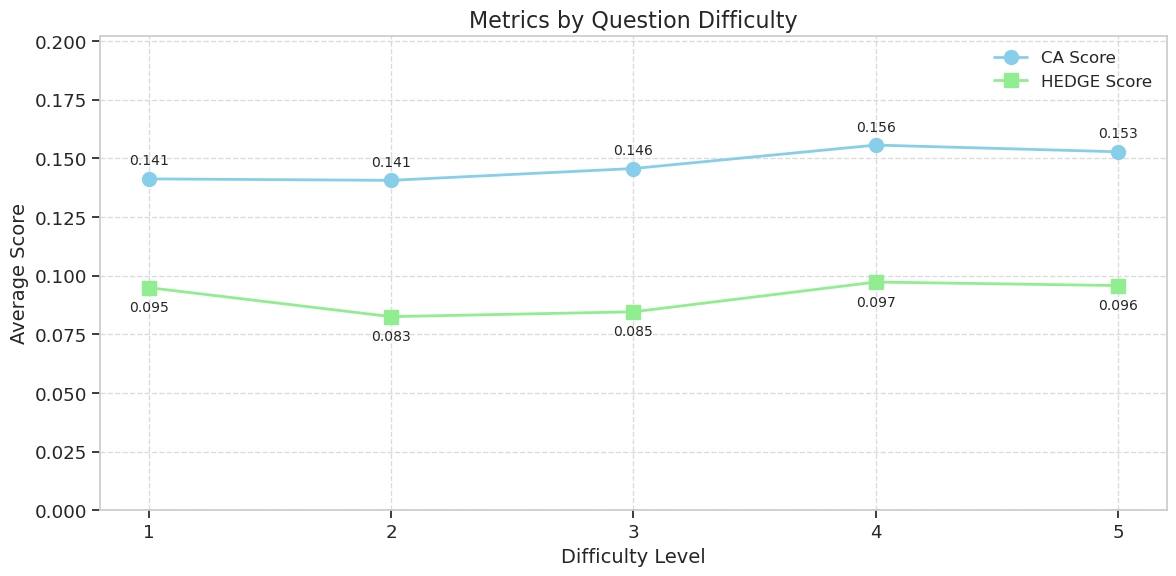

In [15]:
try:
    # Create a line plot of metrics by difficulty
    plt.figure(figsize=(12, 6))

    # Plot CA scores
    plt.plot(difficulty_summary['difficulty_num'], difficulty_summary['ca_score'],
             marker='o', linewidth=2, markersize=10, label='CA Score', color='skyblue')

    # Plot HEDGE scores
    plt.plot(difficulty_summary['difficulty_num'], difficulty_summary['hedge_score'],
             marker='s', linewidth=2, markersize=10, label='HEDGE Score', color='lightgreen')

    # Calculate appropriate y-axis limits based on data
    max_ca = difficulty_summary['ca_score'].max()
    max_hedge = difficulty_summary['hedge_score'].max()
    max_value = max(max_ca, max_hedge)
    y_max = max_value * 1.3  # Add 30% padding above the max value

    # Add labels and title
    plt.title('Metrics by Question Difficulty', fontsize=16)
    plt.xlabel('Difficulty Level', fontsize=14)
    plt.ylabel('Average Score', fontsize=14)
    plt.ylim(0, y_max)
    plt.xticks(difficulty_summary['difficulty_num'])
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)

    # Add value labels
    for i, v in enumerate(difficulty_summary['ca_score']):
        plt.text(difficulty_summary['difficulty_num'].iloc[i], v + (y_max * 0.03), f'{v:.3f}',
                 ha='center', fontsize=10)

    for i, v in enumerate(difficulty_summary['hedge_score']):
        plt.text(difficulty_summary['difficulty_num'].iloc[i], v - (y_max * 0.05), f'{v:.3f}',
                 ha='center', fontsize=10)

    plt.tight_layout()
    plt.show()
except NameError:
    print("No metrics data available.")


## Relationship Between CA and HEDGE Scores

Let's examine the relationship between the CA and HEDGE metrics.


Correlation between CA score and HEDGE score: -0.0848


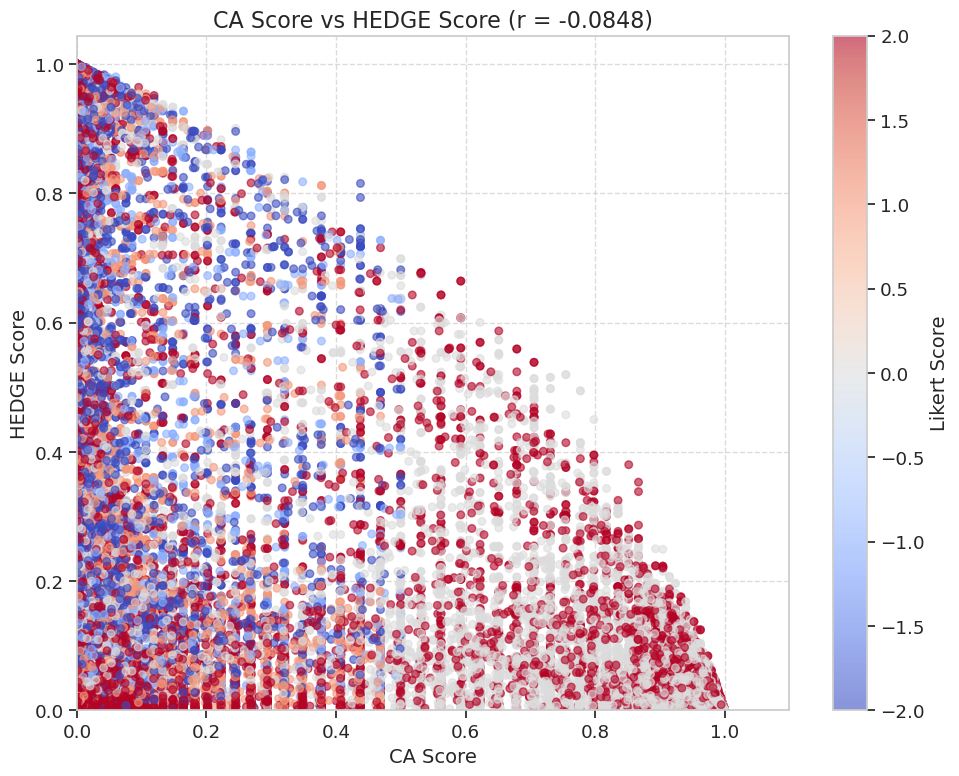

In [20]:
try:
    # Calculate correlation
    corr_ca_hedge = metrics_df['ca_score'].corr(metrics_df['hedge_score'])
    print(f"Correlation between CA score and HEDGE score: {corr_ca_hedge:.4f}")

    # Create scatter plot
    plt.figure(figsize=(10, 8))

    # Plot with color based on Likert score
    scatter = plt.scatter(metrics_df['ca_score'], metrics_df['hedge_score'],
                         c=metrics_df['score'], cmap='coolwarm', alpha=0.6, s=30)

    # Add labels and title
    plt.title(f'CA Score vs HEDGE Score (r = {corr_ca_hedge:.4f})', fontsize=16)
    plt.xlabel('CA Score', fontsize=14)
    plt.ylabel('HEDGE Score', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Set axis limits based on data (using 99th percentile to avoid outliers)
    ca_99th = metrics_df['ca_score'].quantile(0.99)
    hedge_99th = metrics_df['hedge_score'].quantile(0.99)
    plt.xlim(0, ca_99th * 1.1)
    plt.ylim(0, hedge_99th * 1.1)

    # Add color bar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Likert Score', fontsize=14)

    plt.tight_layout()
    plt.show()
except NameError:
    print("No metrics data available.")


## Conclusion

This notebook has provided visualizations and analysis of the Confident-Abstain (CA) and Hedging (HEDGE) metrics across different dimensions of the experimental results. These insights can help understand how different prompt forms, label types, subjects, and difficulty levels affect the model's abstention and hedging behavior.
